# パッキング問題


> ビンパッキング問題， カッティングストック問題， 2次元パッキング問題


In [1]:
#default_exp bpp

In [1]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
import subprocess
import platform
import pandas as pd

import random
import math

from gurobipy import Model, quicksum, GRB, Column
#from mypulp import Model, quicksum, GRB
import networkx as nx

import plotly
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import sys
#sys.path.append('..')
#import opt100.graphtools as gts

folder = "../data/packing/"

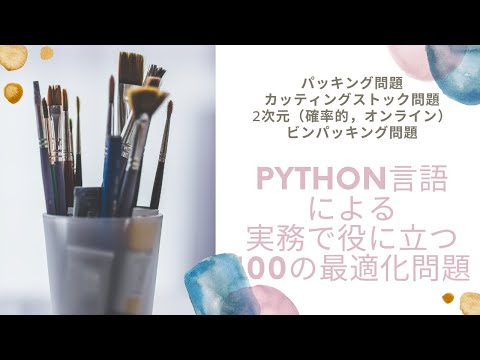

In [3]:
#hide_input
from IPython.display import Image, YouTubeVideo
YouTubeVideo("iLgDpPc-Sl0")

## ビンパッキング問題

**ビンパッキング問題**(bin packing problem; 箱詰め問題)は，以下のように定義される問題である．

$n$個のアイテムから成る有限集合 $N$ とサイズ（容量） $B$ のビンが無限個準備されている．
個々のアイテム $i \in N$ のサイズ $0 \leq w_i \leq B$ は分かっているものとする．
これら $n$ 個のアイテムを，サイズ $B$ のビンに詰めることを考えるとき，
必要なビンの数を最小にするような詰めかたを求める問題．

ビンの数の上限 $U$ が与えられているものとする． アイテム $i$ をビン $j$ に詰めるとき $1$ になる変数 $x_{ij}$ と，
ビン $j$ の使用の可否を表す変数 $y_j$ を用いることによって，ビンパッキング問題は，以下の整数最適化問題として記述できる．

$$
\begin{array}{l l l} 
minimize  & \displaystyle\sum_{j=1}^U  y_{j} &     \\
s.t.  &
 \displaystyle\sum_{j=1}^{U} x_{ij} =1 &  \forall  i =1,2,\ldots,n \\
    & \displaystyle\sum_{i=1}^n w_i x_{ij} \leq B y_j  &  \forall j=1,2,\ldots,U  \\
                 &  x_{ij} \leq y_j & \forall  i=1,2,\ldots,n; j=1,2,\ldots,U \\
                 & x_{ij} \in \{ 0,1 \}    & \forall  i=1,2,\ldots,n; j=1,2,\ldots,U  \\
                 & y_j \in \{ 0,1 \} & \forall  j=1,2,\ldots,U
\end{array}
$$

この定式化は，大規模な実際問題を解く際には使うべきではない．データが整数の場合には，枝フロー変数を用いたより強い定式化が提案されている． 詳細は， 以下のサイトを参照されたい．

https://vpsolver.fdabrandao.pt/


### ヒューリスティクス

ビンの数の上限 $U$ を求めるために簡単はヒューリスティクスを準備しておく．

#### first fit (FF) ヒューリスティクス

アイテムを $1,2,\cdots,n$ の順にビンに詰めていく．
このとき，アイテムは詰め込み可能な最小添字のビンに詰めるものとする．
どのビンに入れてもサイズの上限 $B$ を超えてしまうなら，
新たなビンを用意し，そこに詰める．


このヒューリスティクスは，最適なビン数の $1.7$倍以下のビン数しか使わないという保証をもつ．


#### first fit decreasing (FFD) ヒューリスティクス

アイテムのサイズを非減少順に並べ替えた後に， first fitヒューリスティクスを行う方法． 

このヒューリスティクスは，最悪の場合の性能比率が $11/9$ に漸近することが知られている．


In [1]:
def FFD(s,B):
    """First Fit Decreasing heuristics for the bin Packing Problem.
    Parameters:
        - s: list with item widths
        - b: bin capacity
    Returns a list of lists with bin compositions.
    """    
    remain = [B]        # keep list of empty space per bin
    sol = [[]]          # a list ot items (i.e., sizes) on each used bin
    for item in sorted(s,reverse=True):
        for (j,free) in enumerate(remain):
            if free >= item:
                remain[j] -= item
                sol[j].append(item)
                break
        else: #does not fit in any bin
            sol.append([item])
            remain.append(B-item)
    return sol    
def FF(s,B):
    """First Fit heuristics for the bin Packing Problem.
    Parameters:
        - s: list with item widths
        - b: bin capacity
    Returns a list of lists with bin compositions.
    """    
    remain = [B]        # keep list of empty space per bin
    sol = [[]]          # a list ot items (i.e., sizes) on each used bin
    for item in s:
        for (j,free) in enumerate(remain):
            if free >= item:
                remain[j] -= item
                sol[j].append(item)
                break
        else: #does not fit in any bin
            sol.append([item])
            remain.append(B-item)
    return sol   

In [14]:
def bpp(s,B):
    """bpp: Martello and Toth's model to solve the bin packing problem.
    Parameters:
        - s: list with item widths
        - B: bin capacity
    Returns a model, ready to be solved.
    """
    n = len(s)
    U = len(FFD(s,B)) # upper bound of the number of bins
    model = Model("bpp")
    # setParam("MIPFocus",1)
    x,y = {},{}
    for i in range(n):
        for j in range(U):
            x[i,j] = model.addVar(vtype="B", name="x(%s,%s)"%(i,j))
    for j in range(U):
        y[j] = model.addVar(vtype="B", name="y(%s)"%j)    
    model.update()

    # assignment constraints
    for i in range(n):
        model.addConstr(quicksum(x[i,j] for j in range(U)) == 1, "Assign(%s)"%i)

    # bin capacity constraints
    for j in range(U):
        model.addConstr(quicksum(s[i]*x[i,j] for i in range(n)) <= B*y[j], "Capac(%s)"%j)

    # tighten assignment constraints
    for j in range(U):
        for i in range(n):
            model.addConstr(x[i,j] <= y[j], "Strong(%s,%s)"%(i,j))
        
##    # tie breaking constraints
##    for j in range(b-1):
##        model.addConstr(y[j] >= y[j+1),"Tiebrk(%s)"%j)
##
##    # SOS constraints
##    for i in range(n):
##        model.addSOS(1,[x[i,j] for j in range(b)])

    model.setObjective(quicksum(y[j] for j in range(U)), GRB.MINIMIZE)

    model.update()
    model.__data = x,y
    return model, U


def solvebinPacking(s,B):
    """solvebinPacking: use an IP model to solve the in Packing Problem.
    
    Parameters:
        - s: list with item widths
        - b: bin capacity

    Returns a solution: list of lists, each of which with the items in a roll.
    """
    n = len(s)
    model, U = bpp(s,B)
    x,y = model.__data

    model.optimize()
    
    bins = [[] for i in range(U)]
    for (i,j) in x:
        if x[i,j].X > .5:
            bins[j].append(s[i])
    for i in range(bins.count([])):
        bins.remove([])
    for b in bins:
        b.sort()
    bins.sort()
    return bins


def Discretebniform(n=10,lb=1,ub=99,b=100):
    """Discretebniform: create random, uniform  for the bin packing problem."""
    b = 100
    s = [0]*n
    for i in range(n):
        s[i] = random.randint(lb,ub)
    return s,b

In [16]:
random.seed(256)
s,B = Discretebniform(10,1,50,100)
print ("items:",s)
print ("bin size:",B)

bins = solvebinPacking(s,B)
print (len(bins),"bins:")
print (bins)

items: [32, 20, 28, 24, 25, 3, 30, 50, 28, 16]
bin size: 100
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 43 rows, 33 columns and 123 nonzeros
Model fingerprint: 0x131c1438
Variable types: 0 continuous, 33 integer (33 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve time: 0.00s
Presolved: 43 rows, 33 columns, 123 nonzeros
Variable types: 0 continuous, 33 integer (33 binary)

Root relaxation: cutoff, 24 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         3.00000    3.00000  0.00%     -    0s

Explored 0 nodes (24 simplex iterations) in 0.01 seconds


## カッティングストック問題

ビンパッキング（箱詰め）問題に類似の古典的な問題として**カッティングストック問題**（cutting stock problem; 切断問題）がある．


$m$個の個別の幅をもった注文を，幅 $b$ の原紙から切り出すことを考える．
注文 $i=1,2,\ldots,m$ の幅 $0 \leq w_i \leq b$ と注文数 $q_i$ が与えられたとき，
必要な原紙の数を最小にするような切り出し方を求めよ．


ここでは，切断問題に対する
Gilmore-Gomoryによる**列生成法**(column generation method)を構築する．

幅$b$ の原紙からの $m$種類の注文の $k$番目の切断パターンを，
 $(t_1^k, t_2^k,\ldots,t_m^k)$ とする．
ここで，$t_i^k$ は注文 $i$ が $k$番目の切断パターン $k$ で切り出される数を表す．
また，実行可能な切断パターン（箱詰め問題における詰め合わせ）とは，以下の式を満たすベクトル 
 $(t_1^k, t_2^k,\ldots,t_m^k)$ を指す．
$$
 \sum_{i=1}^m t_i^k \leq b
$$

実行可能な切断パターンの総数を $K$ とする．
切断問題はすべての可能な切断パターンから，
注文 $i$ を注文数 $q_j$ 以上切り出し， かつ使用した原紙数を最小にするように
切断パターンを選択する問題になる．
切断パターン $k$ を採用する回数を表す整数変数 $x_k$ を
用いると，切断問題は以下の整数最適化問題として書くことができる．

$$
\begin{array}{l l l}
 minimize & \displaystyle\sum_{k=1}^K x_k           &                      \\
s.t.       & \displaystyle\sum_{k=1}^K t_i^k x_k \geq q_i  & \forall i=1,2,\ldots,m \\
               & x_k \in \mathbf{Z}_+            & \forall k=1,2,\ldots,K 
\end{array}
$$

これを主問題(master problem)と呼ぶ．
主問題の線形最適化緩和問題を考え，その最適双対変数ベクトルを $\lambda$ とする．
このとき，被約費用が負の列（実行可能な切断パターン）を求める問題は，以下の整数ナップサック問題になる．
$$
\begin{array}{l l l}
maximize & \displaystyle\sum_{i=1}^m \lambda_i y_i  &  \\
s.t.     & \displaystyle\sum_{i=1}^m w_i y_i \leq b &  \\
                       & y_i \in \mathbf{Z}_+     & \forall i=1,2,\ldots,m
\end{array}
$$


In [19]:
LOG = True
EPS = 1.e-6

def solveCuttingStock(w,q,b):
    """solveCuttingStock: use column generation (Gilmore-Gomory approach).
    Parameters:
        - w: list of item's widths
        - q: number of items of a width
        - b: bin/roll capacity
    Returns a solution: list of lists, each of which with the cuts of a roll.
    """
    t = []      # patterns
    m = len(w)
    # generate initial patterns with one size for each item width
    for (i,width) in enumerate(w):
        pat = [0]*m  # vector of number of orders to be packed into one roll (bin)
        pat[i] = int(b/width)
        t.append(pat)

    # if LOG:
    #     print "sizes of orders=",w
    #     print "quantities of orders=",q
    #     print "roll size=",b
    #     print "initial patterns",t

    K = len(t)
    master = Model("master LP") # master LP problem
    x = {}
    for k in range(K):
        x[k] = master.addVar(vtype="I", name="x(%s)"%k)
    master.update()

    orders = {}
    for i in range(m):
        orders[i] = master.addConstr(
            quicksum(t[k][i]*x[k] for k in range(K) if t[k][i] > 0) >= q[i], "Order(%s)"%i)

    master.setObjective(quicksum(x[k] for k in range(K)), GRB.MINIMIZE)

    master.update()   # must update before calling relax()
    master.Params.OutputFlag = 0 # silent mode

    # iter = 0
    while True:
        # print "current patterns:"
        # for ti in t:
        #     print ti
        # print
        
        # iter += 1
        relax = master.relax()
        relax.optimize()
        pi = [c.Pi for c in relax.getConstrs()] # keep dual variables

        knapsack = Model("KP")     # knapsack sub-problem
        knapsack.ModelSense = -1   # maximize
        y = {}
        for i in range(m):
            y[i] = knapsack.addVar(lb=0, ub=q[i], vtype="I", name="y(%s)"%i)
        knapsack.update()

        knapsack.addConstr(quicksum(w[i]*y[i] for i in range(m)) <= b, "Width")
        knapsack.setObjective(quicksum(pi[i]*y[i] for i in range(m)), GRB.MAXIMIZE)
           
        knapsack.Params.OutputFlag = 0 # silent mode
        knapsack.optimize()
        # if LOG:
        #     print "objective of knapsack problem:", knapsack.ObjVal
        if knapsack.ObjVal < 1+EPS: # break if no more columns
            break

        pat = [int(y[i].X+0.5) for i in y]      # new pattern
        t.append(pat)
        # if LOG:
        #     print "shadow prices and new pattern:"
        #     for (i,d) in enumerate(pi):
        #         print "\t%5s%12s%7s" % (i,d,pat[i])
        #     print

        # add new column to the master problem
        col = Column()
        for i in range(m):
            if t[K][i] > 0:
                col.addTerms(t[K][i], orders[i])
        x[K] = master.addVar(obj=1, vtype="I", name="x(%s)"%K, column=col)
        master.update()   # must update before calling relax()
        # master.write("MP" + str(iter) + ".lp")
        K += 1


    # Finally, solve the IP
    # if LOG:
    #     master.Params.OutputFlag = 1 # verbose mode
    master.optimize()

    # if LOG:
    #     print 
    #     print "final solution (integer master problem):  objective =", master.ObjVal
    #     print "patterns:"
    #     for k in x:
    #         if x[k].X > EPS:
    #             print "pattern",k,
    #             print "\tsizes:",
    #             print [w[i] for i in range(m) if t[k][i]>0 for j in range(t[k][i]) ],
    #             print "--> %s rolls" % int(x[k].X+.5)

    rolls = []
    for k in x:
        for j in range(int(x[k].X + .5)):
            rolls.append(sorted([w[i] for i in range(m) if t[k][i]>0 for j in range(t[k][i])]))
    rolls.sort()
    return rolls

    

def CuttingStockExample1():
    """CuttingStockExample1: create toy  for the cutting stock problem."""
    b = 110            # roll width (bin size)  
    w = [20,45,50,55,75]  # width (size) of orders (items)
    q = [48,35,24,10,8]  # quantitiy of orders
    return w,q,b

def CuttingStockExample2():
    """CuttingStockExample2: create toy  for the cutting stock problem."""
    b = 9            # roll width (bin size)  
    w = [2,3,4,5,6,7,8]   # width (size) of orders (items)
    q = [4,2,6,6,2,2,2]  # quantitiy of orders
    return w,q,b


def mkCuttingStock(s):
    """mkCuttingStock: convert a bin packing  into cutting stock format"""
    w,q = [],[]   # list of different widths (sizes) of items, their quantities
    for item in sorted(s):
        if w == [] or item != w[-1]:
            w.append(item)
            q.append(1)
        else:
            q[-1] += 1
    return w,q


def mkbinPacking(w,q):
    """mkbinPacking: convert a cutting stock  into bin packing format"""
    s = []
    for j in range(len(w)):
        for i in range(q[j]):
            s.append(w[j])
    return s

In [21]:
w,q,b = CuttingStockExample1()
rolls = solveCuttingStock(w,q,b)
print (len(rolls),"rolls:")
print (rolls)

47 rolls:
[[20, 20, 20, 20, 20], [20, 20, 20, 50], [20, 20, 20, 50], [20, 20, 20, 50], [20, 20, 20, 50], [20, 20, 20, 50], [20, 20, 20, 50], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 45, 45], [20, 75], [20, 75], [20, 75], [20, 75], [20, 75], [20, 75], [20, 75], [20, 75], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [55, 55], [55, 55], [55, 55], [55, 55], [55, 55]]


## $d$ 次元ベクトルパッキング問題

**$d$ 次元ベクトルパッキング問題** ($d$-dimensioanl vector packing problem) は, 以下のように定義される．

$n$個のアイテムから成る有限集合 $N$ とサイズ（容量） $B$ のビンが $U$ 本準備されている．
個々のアイテム $i \in N$ は $d$次元の属性（サイズ） $(w_i^1, w_i^2, \ldots ,w_i^d)$ をもつ．
これら $n$ 個のアイテムを，容量 $B$ （これは次元によらず一定である）のビンに詰めることを考える．

アイテム集合 $N$ の $U$ 個のビンへの分割を $P_1,P_2,\ldots,P_U$ とする． 
ただし，ビンに割り振られたアイテムのサイズの合計がビンのサイズを超えないようにしたい．
$$
\sum_{i \in P_j} w_i^k \leq B \ \ \ \forall j = 1,2,\ldots,U, k=1,2,\ldots,d
$$
この条件を満たすアイテムのビンへの分割を求めよ．

ビンのサイズが一定でなく，次元ごとの上限が異なる問題は，**変動サイズベクトルパッキング問題**(variable size vector packing problem)とよばれ，
データセンターにおけるプロセスのマシンへの割当や，トラックへの荷物の割当に応用をもつ．
以下では，ビン $j$ を使用したときの費用 $c_j$ を導入し，最適化問題として定式化する．

アイテム $i$ をビン $j$ に詰めるとき $1$ になる変数 $x_{ij}$ と，
ビン $j$ の使用の可否を表す変数 $y_j$ を用いることによって，変動サイズベクトルパッキング問題は，以下の整数最適化問題として記述できる．

$$
\begin{array}{l l l} 
minimize  & \displaystyle\sum_{j=1}^U  c_j y_{j} &     \\
s.t.  &
   \displaystyle\sum_{j=1}^{U} x_{ij} =1 &  \forall  i =1,2,\ldots,n \\
    & \displaystyle\sum_{i=1}^n w_i^k x_{ij} \leq B_j^k y_j  &  \forall j=1,2,\ldots,U; k=1,2,\ldots,d  \\
                 &  x_{ij} \leq y_j & \forall  i=1,2,\ldots,n; j=1,2,\ldots,U \\
                 & x_{ij} \in \{ 0,1 \}    & \forall  i=1,2,\ldots,n; j=1,2,\ldots,U  \\
                 & y_j \in \{ 0,1 \} & \forall  j=1,2,\ldots,U
\end{array}
$$

以下のプログラムでは，実行不能性を避けるために，割り当てできないアイテムの数を最小化し，その中で使用したビンの費用を最小化するように変更している．

In [14]:
def vbpp(s,B,c,penalty=1000.):
    n = len(s)
    U = len(c)
    model = Model("bpp")
    # setParam("MIPFocus",1)
    x, y, z = {},{},{}
    for i in range(n):
        z[i] = model.addVar(vtype="B", name= f"z({i})")
        for j in range(U):
            x[i,j] = model.addVar(vtype="B", name= f"x({i},{j})")
    for j in range(U):
        y[j] = model.addVar(vtype="B", name= f"y({j})")    
    model.update()
    # assignment constraints
    for i in range(n):
        model.addConstr(quicksum(x[i,j] for j in range(U)) + z[i] == 1, f"Assign({i})")
    # tighten assignment constraints
    for j in range(U):
        for i in range(n):
            model.addConstr(x[i,j] <= y[j], f"Strong({i},{j})")
    # bin capacity constraints
    for j in range(U):
        for k in range(d):
            model.addConstr(quicksum(s[i,k]*x[i,j] for i in range(n)) <= B[j,k]*y[j], f"Capac({j},{k})")
    model.setObjective(quicksum(penalty*s[i,k]*z[i] for i in range(n) for k in range(d)) + quicksum(c[j]*y[j] for j in range(U)), GRB.MINIMIZE)

    model.update()
    model.__data = x,y,z
    return model

In [4]:
pip install mypulp

Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
from mypulp import *
np.random.seed(123)
n = 5
U = 2
d = 2
lb = 3
ub = 10
blb = 15
bub = 20
penalty = 1000
s = np.random.randint(lb,ub,(n,d))
B = np.random.randint(blb,bub, (U,d))
c = np.random.randint(500,1000,U)

model = vbpp(s,B,c,penalty)
model.optimize()
    
x,y,z = model.__data
bins = [[] for j in range(U)]
for (i,j) in x:
    if x[i,j].X > .5:
        bins[j].append(s[i])
unassigned =[]
for i in z:
    if z[i].X > .5:
        unassigned.append(s[i])
        
print("item", s)
print("unassigned items=", unassigned)
for j in range(U):
    weight = np.zeros(d, dtype=int)
    for s in bins[j]:
        weight += s
    print(weight, "<=", B[j])
print(weight)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/e1c9642869364e91b986a6e4a2c92afa-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/e1c9642869364e91b986a6e4a2c92afa-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 24 COLUMNS
At line 125 RHS
At line 145 BOUNDS
At line 163 ENDATA
Problem MODEL has 19 rows, 17 columns and 59 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9905.67 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 17 rows, 17 columns (17 integer (17 of which binary)) and 57 elements
Cutoff increment increased from

### ヒューリスティクス

変動サイズベクトルパッキング問題に対しては，BFD (Best Fit Decreasing) の変形が提案されている．

与えられた $U$ 本のビンに．容量を超えない割り当てが可能かどうかを判定する問題を考える．

残りのアイテムの集合を $NR$，　残りのビンの集合を $BR$ とする．
次元$k$のアイテムのサイズの和を $W_k$ とする．
$$
 W_k = \sum_{i \in NR} w_i^k
$$
ビン $j$ の $k$ 次元の残り容量を $r_j^k$ とする． 次元$k$の残り容量の和を $R_k$ とする．
$$
 R_k = \sum_{j \in BR} r_j^k
$$

$W_k$ が大きい次元ほど， $R_k$ が小さい次元ほど重要度が高いと考え， 次元 $k$ の重要度（次元を統合したサイズ）を表す $s_k$ を導入する．
$s_k$ は以下の3通りが考えられる．
$$ s_k = W_k $$
$$ s_k = 1/R_k $$
$$ s_k = W_k/R_k $$

より一般的に，パラメータ $0 \leq \alpha \leq 2$ を用いて以下のように定義する．
$$ s_k = (W_k)^{\alpha} / (R_k)^{2-\alpha} $$


この尺度を用いてビン $j$ の（次元を統合した）サイズ 
$$
\sum_{k=1}^d  s_k r_j^k \ \ \ \forall j \in BR
$$
とアイテム $i$ のサイズ
$$
\sum_{k=1}^d  s_k w_i^k \ \ \ \forall i \in NR
$$
を計算する．

この新たなサイズを用いてBFDヒューリスティクスは，アイテム中心型とビン中心型の2通りが定義できる．

#### アイテム中心型BFDヒューリスティクス

未割当アイテムに対して以下の操作を繰り返す： 
1. （次元を統合した）サイズを計算
2. サイズが最大のアイテムを，割り当て可能な最小の残りサイズをもつビンに割り当てる．（どのビンにも割り当て不能なら終了；実行不能）

実際問題を解く際には，単に実行不能を返すだけでなく，なるべく多くのアイテムを詰めたいので，終了判定条件を変える必要がある．


#### ビン中心型BFDヒューリスティクス

残りのビン集合に対して以下の操作を繰り返す： 
1. （次元を統合した）ビンのサイズを計算
2. サイズが最小のビンを選択
3. 未割当のアイテムに対してサイズを計算し，ビンに入る最大のものを入れる

終了後に未割当のアイテムが残っていたら実行不能


In [2]:
bins = [[] for j in range(3)]
bins = [[]] * 3
print(bins)

[[], [], []]


In [5]:
def BDF(w, B, alpha=1.):
    """
    Item Based Best Fit Decreasing (BFD) heuristcs for variable size vector packing problem
    """
    n, d = w.shape
    U = len(B)
    unassigned = []
    bins = [[] for j in range(U)]
    while len(w)>0:
        W = w.sum(axis=0) #アイテムに対する残りサイズの和（次元ごと）
        R = B.sum(axis=0) #ビンに対する残り容量の和（次元ごと）
        s = (W**alpha)/(R+0.000001)**(2.-alpha) #次元の重要度
        BS = B@s #ビンのサイズ（次元統合後）
        WS = w@s #アイテムのサイズ（次元統合後）
        max_item_idx = np.argmax(WS)
        max_item = w[max_item_idx]
        for j in np.argsort(BS):
            remain = B[j]- max_item
            if np.all(remain>=0): #詰め込み可能
                B[j]= remain
                bins[j].append(max_item)
                break
        else:
            unassigned.append(max_item)
        w = np.delete(w, max_item_idx, axis=0)
    return bins, unassigned

In [6]:
import numpy as np
np.random.seed(123)
n = 5
U = 2
d = 2
lb = 3
ub = 10
blb = 15
bub = 20
w = np.random.randint(lb,ub,(n,d))
B = np.random.randint(blb,bub, (U,d))
bins, unassigned = BDF(w, B, alpha=1.)
print("Bins=", bins)
print("Unassigned=", unassigned)

Bins= [[array([9, 5]), array([9, 4])], [array([9, 8]), array([7, 5])]]
Unassigned= [array([6, 5])]


In [7]:
import numpy as np
B = np.random.randint(15,20, (2,2))
print(B)

[[16 16]
 [15 15]]


アイテム中心型BFDヒューリスティクスに対して，パラメータ $\alpha$ を変化させたときの実験を行う．

In [55]:
#実験
import numpy as np
np.random.seed(123)
n = 1000
U = 100
d = 10
lb = 3
ub = 10
blb = 15
bub = 20
w0 = np.random.randint(lb,ub,(n,d))
B0 = np.random.randint(blb,bub, (U,d))
#c0 = np.random.randint(500,1000,U)
x, y, z =[],[],[]
for k in np.arange(0.0, 2.1, 0.01):
    w = w0.copy()
    B = B0.copy()
    # alpha = float(k)/100.
    alpha = k
    unassigned = []
    bins = [[] for j in range(U)]
    while len(w)>0:
        W = w.sum(axis=0)
        R = B.sum(axis=0) #残り容量の和（次元ごと）
        #print(W,1/R,W/R)
        #次元の重要度
        #s = W
        #s = W/(R+0.000001) 
    #    s = 1/(R+0.000001) #次元の重要度
        s = (W**alpha)/(R+0.000001)**(2.-alpha) 
    #     print("s=", s)
    #     print("B=",B)
        BS = B@s #ビンのサイズ（次元統合後）
    #     print("BS",BS)
    #     print("w=",w)
        WS = w@s #アイテムのサイズ（次元統合後）
    #     print("WS",WS)
        max_item_idx = np.argmax(WS)
        max_item = w[max_item_idx]
        #print("max item",max_item)
        for j in np.argsort(BS):
            remain = B[j]- max_item
            if np.all(remain>=0): #詰め込み可能
                B[j]= remain
                bins[j].append(max_item)
                break
        else:
            #print("Failed to pack!")
            unassigned.append(max_item)
        #print(B)
        w = np.delete(w, max_item_idx, axis=0)
        #print(w)
    #print(alpha,len(unassigned), np.sum(unassigned))
    x.append(alpha)
    y.append(len(unassigned))
    z.append(np.sum(unassigned))

In [5]:
import pandas as pd
df_none = pd.read_csv('./results_correlated_mf-0.8_rem_cons-0.8_sd-0.1_coritems-True.csv', sep=';')

In [7]:
import pandas as pd
df_none = pd.read_csv('./test.csv', sep=';')

In [12]:
df_none['R/C_ns']

0    69
1     3
2    29
3    65
4     0
5     0
6    98
7     0
8     0
Name: R/C_ns, dtype: int64

In [14]:
df_none.columns
# ns -> number of success
# pn -> packed / total -> 積載率

Index(['#bins ', ' #resources', ' Avg #items ', ' Avg %usage ',
       ' Avg max % usage', 'nothing_pn', 'nothing_ns', 'shuff1_pn',
       'shuff1_ns', '1/C_pn', '1/C_ns', '1/R_pn', '1/R_ns', 'R/C_pn', 'R/C_ns',
       'ic_shuff_pn', 'ic_shuff_ns', 'ic_dyn_1/C_pn', 'ic_dyn_1/C_ns',
       'ic_dyn_1/R_pn', 'ic_dyn_1/R_ns', 'ic_dyn_R/C_pn', 'ic_dyn_R/C_ns',
       'bc_shuff_pn', 'bc_shuff_ns', 'bc_dyn_1/C_pn', 'bc_dyn_1/C_ns',
       'bc_dyn_1/R_pn', 'bc_dyn_1/R_ns', 'bc_dyn_R/C_pn', 'bc_dyn_R/C_ns',
       'bb_nothing_pn', 'bb_nothing_ns', 'bb_shuff1_pn', 'bb_shuff1_ns',
       'bb_shuff_pn', 'bb_shuff_ns', 'bb_st_1/C_pn', 'bb_st_1/C_ns',
       'bb_dyn_1/C_pn', 'bb_dyn_1/C_ns', 'bb_st_1/R_pn', 'bb_st_1/R_ns',
       'bb_dyn_1/R_pn', 'bb_dyn_1/R_ns', 'bb_st_R/C_pn', 'bb_st_R/C_ns',
       'bb_dyn_R/C_pn', 'bb_dyn_R/C_ns', 'sbb_nothing_pn', 'sbb_nothing_ns',
       'sbb_shuff1_pn', 'sbb_shuff1_ns', 'sbb_shuff_pn', 'sbb_shuff_ns',
       'sbb_st_1/C_pn', 'sbb_st_1/C_ns', 'sbb_dyn_1/C_pn',

In [56]:
# x: alpha, y: 残りアイテム数, z: 残りアイテム容量
df = pd.DataFrame({"x":x, "y":y, "z":z})
import plotly.express as px
# fig = px.scatter(df, x="y", y="z")
fig = px.line(df, x="x", y="z")
plotly.offline.plot(fig);

In [51]:
df = pd.DataFrame({"x":x, "y":y, "z":z})
df


,x,y,z
0,0.0,800,46292
1,0.1,800,46273
2,0.2,800,46264
3,0.3,800,46273
4,0.4,800,46267
5,0.5,800,46259
6,0.6,800,46249
7,0.7,800,46250
8,0.8,800,46248
9,0.9,800,46238


In [113]:
#実験
import numpy as np
# np.random.seed(123)
# # n = 1000
# # U = 2
# # d = 2
# # lb = 3
# # ub = 10
# # blb = 15
# # bub = 20
# w0 = np.random.randint(lb,ub,(n,d))
# B0 = np.random.randint(blb,bub, (U,d))
# #c0 = np.random.randint(500,1000,U)

def test_bdf(d,b0,lb,ub):
    np.random.seed(123)
    # d -> 瓶の次元
    # U -> 瓶の本数
    n = 1000
    w0 = np.random.randint(lb,ub,(n,d))

    x, y, z =[],[],[]
    c = 0
    
    check_percents = [0.25, 0.5, 0.75, 1.0]
    for k in np.arange(0.0, 2.0, 0.01):
        if k / 2.0 in check_percents:
            print(f'Processing {(k/2.0)*100}% Done')
        w = w0.copy()
        B = b0.copy()
        # alpha = float(k)/100.
        alpha = k
        unassigned = []
        bins = [[] for j in range(U)]
        while len(w)>0:
            W = w.sum(axis=0)
            R = B.sum(axis=0) #残り容量の和（次元ごと）
            #print(W,1/R,W/R)
            #次元の重要度
            #s = W
            #s = W/(R+0.000001) 
        #    s = 1/(R+0.000001) #次元の重要度
            s = (W**alpha)/(R+0.000001)**(2.-alpha) 
        #     print("s=", s)
        #     print("B=",B)
            BS = B@s #ビンのサイズ（次元統合後）
        #     print("BS",BS)
        #     print("w=",w)
            WS = w@s #アイテムのサイズ（次元統合後）
        #     print("WS",WS)
            max_item_idx = np.argmax(WS)
            max_item = w[max_item_idx]
            #print("max item",max_item)
            for j in np.argsort(BS):
                remain = B[j]- max_item
                if np.all(remain>=0): #詰め込み可能
                    B[j]= remain
                    bins[j].append(max_item)
                    break
            else:
                #print("Failed to pack!")
                unassigned.append(max_item)
            #print(B)
            w = np.delete(w, max_item_idx, axis=0)
            #print(w)
        #print(alpha,len(unassigned), np.sum(unassigned))
        x.append(alpha)
        y.append(len(unassigned))
        z.append(np.sum(unassigned))
    return x, y, z

In [103]:
1.0 / 2.0 

0.5

In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [99]:
import glob


print(glob.glob('experiment_*'))

['experiment_[100, 400]_10.html', 'experiment_[100, 400]_2.html', 'experiment_[100, 400]_5.html', 'experiment_[100, 400]_50.html']


In [108]:
for path in glob.glob('exp_*'):
    print(path)
    os.remove(path)

exp_[1, 1000]_D10_B10.html
exp_[1, 1000]_D10_B100.html
exp_[1, 1000]_D10_B30.html
exp_[1, 1000]_D2_B10.html
exp_[1, 1000]_D2_B100.html
exp_[1, 1000]_D2_B30.html
exp_[1, 1000]_D50_B10.html
exp_[1, 1000]_D50_B100.html
exp_[1, 1000]_D50_B30.html
exp_[1, 1000]_D5_B10.html
exp_[1, 1000]_D5_B100.html
exp_[1, 1000]_D5_B30.html
exp_[100, 400]_D10_B10.html
exp_[100, 400]_D10_B100.html
exp_[100, 400]_D10_B30.html
exp_[100, 400]_D2_B10.html
exp_[100, 400]_D2_B100.html
exp_[100, 400]_D2_B30.html
exp_[100, 400]_D50_B10.html
exp_[100, 400]_D50_B100.html
exp_[100, 400]_D50_B30.html
exp_[100, 400]_D5_B10.html
exp_[100, 400]_D5_B100.html
exp_[100, 400]_D5_B30.html
exp_[200, 800]_D10_B10.html
exp_[200, 800]_D10_B100.html
exp_[200, 800]_D10_B30.html
exp_[200, 800]_D2_B10.html
exp_[200, 800]_D2_B100.html
exp_[200, 800]_D2_B30.html
exp_[200, 800]_D50_B10.html
exp_[200, 800]_D50_B100.html
exp_[200, 800]_D50_B30.html
exp_[200, 800]_D5_B10.html
exp_[200, 800]_D5_B100.html
exp_[200, 800]_D5_B30.html
exp_[25, 1

In [121]:
import pandas as pd
import plotly
import os
import plotly.express as px

item_ranges = [[100, 400], [1, 1000], [200, 800], [50, 200], [25, 100]]
dimentions = [2, 5, 10, 25, 50]
bins = [10, 30, 100]
if not os.path.exists('exp'):
    os.makedir('exp')
for bin in bins:
    for dim in dimentions:
        blb = 10
        bub = 1000
        bins = np.random.randint(blb,bub, (bin,dim))
        os.makedirs(f'exp/B_{bin}_D_{dim}', exist_ok=True)
        for item_range in item_ranges:
            print(f'bin:{bin}. item_range:{item_range}, dim:{dim}')
            filename = f'exp/B_{bin}_D_{dim}/{item_range}.html'
            if os.path.exists(filename):
                break
            alpha_arr, unassigned_count, unassigned_total= test_bdf(d=dim, b0=bins, lb=item_range[0], ub=item_range[1])
            df = pd.DataFrame({
                "alpha": alpha_arr, 
                # "unassigned_count": unassigned_count, 
                "unassigned_total": unassigned_total
                })
            
            fig = px.line(df, x="alpha", y="unassigned_total")
            plotly.offline.plot(fig, filename=filename)


# alpha_arr, unassigned_count, unassigned_total, bins = test_bdf(d=5, U=100)
# # alpha_arr: alpha, unassigned_count: 残りアイテム数, unassigned_total: 残りアイテム容量
# df = pd.DataFrame({
#                 "alpha": alpha_arr, 
#                 # "unassigned_count": unassigned_count, 
#                 "unassigned_total": unassigned_total
#                 })
# import plotly.express as px
# filepath = './temp-plot.html'
# if os.path.exists(filepath):
#     os.remove(filepath)
    
# fig = px.line(df, x="alpha", y="unassigned_total")
# #fig = px.line(df, x="x", y="z")
# plotly.offline.plot(fig, filename='test.html')

bin:10. item_range:[100, 400], dim:2
bin:10. item_range:[100, 400], dim:5
bin:10. item_range:[100, 400], dim:10
bin:10. item_range:[100, 400], dim:25
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
bin:10. item_range:[1, 1000], dim:25
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
bin:10. item_range:[200, 800], dim:25
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
bin:10. item_range:[50, 200], dim:25
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
bin:10. item_range:[25, 100], dim:25
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
bin:10. item_range:[100, 400], dim:50
bin:30. item_range:[100, 400], dim:2
bin:30. item_range:[100, 400], dim:5
bin:30. item_range:[100, 400], dim:10
bin:30. item_range:[100, 400], dim:25
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
bin:30. item_range:[1, 1000], dim:25
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
bin:30. item_r

In [71]:
df

,alpha,unassigned_total
0,0.00,173963
1,0.01,173963
2,0.02,173963
3,0.03,173963
4,0.04,173963
...,...,...
195,1.95,175746
196,1.96,175746
197,1.97,175746
198,1.98,175746


In [8]:
blb = 15
bub = 20
U = 10
B0 = np.random.randint(blb,bub, (U,d))
B0_sum = B0.sum(axis=0)
print(B0_sum)

[172 171]


In [10]:
# r_k^j -> bin kのj次元における残り容量
# まずはビンの容量を決める

# d=2, U=10
d = 2
U = 10
blb = 10
bub = 1000
B0 = np.random.uniform(blb,bub, (U,d))
print(B0)

[[165.06488398  89.65143774]
 [821.12466104 102.2549191 ]
 [301.67564627 556.08665619]
 [797.64118808 154.56525601]
 [704.18778733 108.6721116 ]
 [581.14769362 432.47302469]
 [380.45017886 374.81929747]
 [380.69011998 236.9710838 ]
 [397.54436999 801.62772452]
 [469.34810036 371.2299027 ]]


In [11]:
# アイテム配列作成
w0 = []
for i in range(100):
    
    

[165.06488398  89.65143774]
[821.12466104 102.2549191 ]
[301.67564627 556.08665619]
[797.64118808 154.56525601]
[704.18778733 108.6721116 ]
[581.14769362 432.47302469]
[380.45017886 374.81929747]
[380.69011998 236.9710838 ]
[397.54436999 801.62772452]
[469.34810036 371.2299027 ]


次元はそれぞれ2, 5, 10　　
ビンはそれぞれ 10, 30, 100　　
アイテムの個数は100こ　　

In [ ]:
# １つ目のインスタンス
# ビン容量は10 - 1000のrandom uniformから独立して選ばれる
# アイテムサイズは、0 - r_k^jのrandom uniformから選択される

d = [2, 5, 10]

In [37]:
import itertools
import operator


################## Utility functions ####################
def maxl(list):
    """ Return max using size attribute """
    return max(list, key=lambda x: x.size)

def minl(list):
    """ Return min using size attribute """
    return min(list, key=lambda x: x.size)

def sortl(list, dec=True):
    """ Sort list using size attribute.
    Items are sorted by decreasing order if rev = True,
    by increasing order otherwise """
    list.sort(key=lambda x: x.size, reverse=dec)
    return list


##################  ####################

class Instance:
    """ An instance """
    def __init__(self, items, bins):
        self.items = items[:]
        self.bins = bins[:]

    def __repr__(self):
        return "Items:\n"+str(self.items)+"\nBins:\n"+str(self.bins)

    def empty(self):
        for i in self.items: i.size = 0
        for b in self.bins: b.empty()


################## Items ####################

class Item:
    """ An item """
    def __init__(self, requirements):
        self.requirements = requirements[:]
        self.size = 0

    def __repr__(self):
        return str(self.requirements)

def vp_lower_bound(items, tbin):
    """ Return a lower bound on the minimum number of bins required
    assuming that all bins have the same capacities as tbin.
    This is a lower bound for the vector packing problem """
    
    """
    全てのビンがbinと同じ容量を持つと仮定して、必要なビンの最小数の下界を返す
    これはベクトルパッキング問題に対する下界である
    """

    if not items: return 0

    reqs = [0] * len(tbin.capacities)
    for i in items:
        reqs = map(operator.add, reqs, i.requirements)

    nbins = 0
    for w, c in zip(reqs, tbin.capacities):
        nb = w / c
        if w % c: nb += 1
        nbins = max(nbins, nb)

    return nbins

################## Bins ####################

class Bin:
    """ A bin """
    def __init__(self, capacities):
        self.capacities = capacities[:]
        self.remaining = capacities[:]
        self.items = []
        self.size = 0

    def __repr__(self):
        return str([self.capacities,self.remaining])

    def feasible(self, item):
        """ Return True iff item can be packed in this bin """
        for req, rem in itertools.zip_longest(item.requirements,self.remaining):
            if (req > rem):
                return False
        return True

    def insert(self, item):
        """
            Adds item to the bin
            Requires: the assignment is feasible
        """
        for i, req in enumerate(item.requirements):
            self.remaining[i] -= req
        self.items.append(item)

    def add(self, item):
        """
            Test feasibility and add item to the bin
            Return True if the item has been added, False o.w.
        """
        if self.feasible(item):
            self.insert(item)
            return True
        return False

    def empty(self):
        """ Empty the bin """
        self.items = []
        self.remaining = self.capacities[:]

In [ ]:
def volume(item, bin):
    """ Return a float in [0 ; 1] corresponding to the percentage
    of capacity used from the bin """
    
    """
    ビンで使用された容量のパーセンテージを[0;1]のfloatで返す
    """
    
    ll = len(item.requirements) # 残っているアイテムの容量?
    sm = 0
    for x in zip(item.requirements, bin.capacities):
        if x[0] > x[1]: return 2.0; # item cannot be packed # 残っているアイテム容量 > ビンの容量
        if x[1]: sm += float(x[0])/x[1] # 
        else: ll -= 1

    return sm/ll

In [19]:
import random
import itertools


################## Constants ####################
MAX_NUM_RES = 101
MAX_RES = 1000
MIN_RES = 10
MAX_TRY = 100 # max number of try to generate an item


################## Utility functions ####################
def volume(item, bin):
    """ Return a float in [0 ; 1] corresponding to the percentage
    of capacity used from the bin """
    
    """
    ビンで使用された容量のパーセンテージを[0;1]のfloatで返す
    """
    
    ll = len(item.requirements)
    sm = 0
    for x in zip(item.requirements, bin.capacities):
        if x[0] > x[1]: return 2.0; # item cannot be packed
        if x[1]: sm += float(x[0])/x[1]
        else: ll -= 1

    return sm/ll
    #return sum(map(lambda x: float(x[0])/x[1] if x[1] else 1.0,
    #        itertools.izip(item.requirements,bin.capacities))) / len(item.requirements)


def update(items, item_req, bin, cur_vol):
    """
    items: アイテムの配列
    item_req: 1つのアイテム(d次元)
    bin: ビンインスタンス
    item_vol: 
    """
    
    if max(item_req) <= 0: return False # アイテムのd次元のサイズが0が最大値ならfalse [0, 0, 0]とか
    it = Item(item_req)
    if bin.add(it): # ビンにitem追加できるか確認後, 追加してTrueを返す
        items.append(it) # アイテム配列にアイテムを追加
        # print('update volume', volume(it, bin))
        return cur_vol + volume(it,bin) # item_vol + ビンの使用量
    return False


################## Instances generator ####################

def unif_bin(num_resources, min_fill, rem_cons=1.0, proc_rate = 1.0, minr=MIN_RES, maxr=MAX_RES):
    """
    Makes a bin containing non-correlated items and
    Either Volume(items) > min_fill or a 0 weighted item was generated
    If proc_rate < 1, the last resource is rare :
    it is 0 with probability proc_rate
    Item capacities are generated in [0,rem_cons*b.remaining]
    """
    
    """
    非相関のアイテムを含むビンを作成し、
    Volume(items) > min_fill か, 重さが0のアイテムを生成する.
    proc_rate < 1の場合, 最後のリソース(次元)は希少であり、サイズ?はproc_rateの確率で0になる？？
    確率(proc_rate)が0の場合? -> アイテム容量は[0, rem_cons*b.remaining]
    """

    mf = min(min_fill, 1-1e-15) # 数値の不安定さを解消するのに役立つ
    bin_cap = [random.randint(minr,maxr) for x in range(num_resources)] # d次元個のリスト
    if (proc_rate < 1) and (random.random() > proc_rate):
        bin_cap[-1] = 0
    b = Bin(bin_cap)
    item_vol = 0.0
    items = []
    while item_vol < mf:
        # rem_cons -> 0.8??
        # ビン容量が80%以下の時[0;0.8*r_k^j]からアイテムサイズを取り出す
        it_res = [random.randint(0,int(rem_cons*x)) for x in b.remaining]
        item_vol = update(items, it_res, b, item_vol)
        # print('item_vol', item_vol)
        if not item_vol: break
        prev_vol = item_vol
    # print('items:', items)
    # print('bins:', b)
    # print()
    return items, b

def correlated_capacities(num_resources, min_fill, dev=.05,
                          rem_cons=1.0, correlated_items = False, minr=MIN_RES, maxr=MAX_RES):
    """
    Generates a bin. Bin capacities are correlated,
    and if correlated_items is True item requirements are correlated
    Either Volume(items) > min_fill or a 0 weighted item was generated
    base*dev is the standard deviation
    Item capacities are generated in [0,rem_cons*b.remaining]
    """
    mf = min(min_fill, 1-1e-15) # helps getting rid of numerical instabilities
    base = random.randint(minr,maxr)
    mean = base*dev
    lbd = 1.0/mean
    bin_cap = [max(0,int(round(base+(random.expovariate(lbd)-mean))))
               for x in range(num_resources)]
    b = Bin(bin_cap)
    item_vol = 0.0
    items = []
    while item_vol < mf:
        if correlated_items:
            for tr in range(MAX_TRY):
                base = random.randint(1,int(rem_cons*min(bin_cap)))
                mean = base*dev
                lbd = 1.0/mean
                it_res = [max(0,int(round(base+(random.expovariate(lbd)-mean))))
                      for x in range(num_resources)]
                vl = update(items, it_res, b, item_vol)
                if vl: break
            item_vol = vl
        else:
            it_res = [random.randint(0,int(rem_cons*x)) for x in b.remaining]
            item_vol = update(items, it_res, b, item_vol)
        if not item_vol: break

    return items, b

def similar_items(num_resources, min_fill, base_item, dev=.05, minr=MIN_RES, maxr=MAX_RES):
    """
    Generates a bin. Bin capacities are not correlated.
    All items are similar to the given base item
    base*dev is the standard deviation
    """
    mf = min(min_fill, 1-1e-15) # helps getting rid of numerical instabilities

    base = random.randint(minr,maxr)
    mean = base*dev
    lbd = 1.0/mean
    bin_cap = base_item.requirements[:]
    for i,v in enumerate(bin_cap):
        base = 5*v
        mean = base*dev
        lbd = 1.0/mean
        bin_cap[i] = max(0,int(round(base+(random.expovariate(lbd)-mean))))

    b = Bin(bin_cap)
    item_vol = 0.0
    items = []
    vl = 0
    while item_vol < mf:
        for tr in range(MAX_TRY):
            it_res = base_item.requirements[:]
            for i,base in enumerate(it_res):
                mean = base*dev
                lbd = 1.0/mean
                it_res[i] = max(0,int(round(base+(random.expovariate(lbd)-mean))))
            vl = update(items, it_res, b, item_vol)
            if vl : break
        item_vol = vl
        if not item_vol: break

    return items, b


def similar(num_resources, min_fill, dev=.05, minr=MIN_RES, maxr=MAX_RES):
    """
    Generates a bin using a uniform distribution. Bin capacities are not correlated.
    This bin contains items with weight ~ cap/5 + exponential perturbation
    base*dev is the standard deviation
    """
    mf = min(min_fill, 1-1e-15) # helps getting rid of numerical instabilities
    # generates bin
    bin_cap = [random.randint(minr,maxr) for x in range(num_resources)]
    b = Bin(bin_cap)

    item_vol = 0.0
    items = []
    vl = 0
    while item_vol < mf:
        for tr in range(MAX_TRY):
            it_res = [bc/5. for bc in bin_cap]
            for i,base in enumerate(it_res):
                mean = base*dev
                lbd = 1.0/mean
                it_res[i] = max(0,int(round(base+(random.expovariate(lbd)-mean))))
            vl = update(items, it_res, b, item_vol)
            if vl : break
        item_vol = vl
        if not item_vol: break

    return items, b


def generator(num_bins, num_resources, min_fill, bin_generator = unif_bin, seed=-1, **kwargs):
    """
    Generates a non-correlated, uniformly distributed instance,
    with num_bins bins and Volume(items) < min_fill * Volume(bin)
    for any set of items in a bin.
    The instance is guaranteed to be feasible.
    """
    assert 0.0 < min_fill <= 1.0
    assert num_resources < MAX_NUM_RES
    if seed != -1: random.seed(seed)
    items = []
    bins = []
    for i in range(num_bins):
        it, bi = bin_generator(num_resources, min_fill, **kwargs)
        # print('it', it)
        # print('bi', bi)
        items.extend(it) # 末尾に別のリストを追加できる
        bins.append(bi) # 

    random.shuffle(items)
    random.shuffle(bins)
    return Instance(items, bins)


In [129]:
MAX_NUM_RES = 101
MAX_RES = 1000
MIN_RES = 10
print(unif_bin(3, .8))

before_b [[744, 900, 705], [744, 900, 705]]
items [[147, 381, 684], [240, 80, 20], [29, 388, 1]]
after_b [[744, 900, 705], [328, 51, 0]]
([[147, 381, 684], [240, 80, 20], [29, 388, 1]], [[744, 900, 705], [328, 51, 0]])


In [6]:
len(iss1.items)

286

In [21]:
# binの数によって数がアイテムの数が変化する
iss1 = generator(num_bins=100, num_resources=3, min_fill=.8, bin_generator = unif_bin, seed=123)
# iss1.bins #(0: bin容量, 1: 残り容量)
# iss1.items

In [ ]:
# 
benchmark(instance_type='unif',min_fill=.8,rem_cons=.8)
benchmark(instance_type='unif-rare',min_fill=.8,rem_cons=.8,rt=.25)
benchmark(instance_type='correlated',min_fill=.8,rem_cons=.8,dev=.1)
benchmark(instance_type='correlated',min_fill=.8,rem_cons=.8,dev=.1,correlated_items=True)
benchmark(instance_type='similar',min_fill=.7,dev=.2)

In [103]:
d = 3
U = 3
blb = 10
bub = 1000
B0 = np.random.uniform(blb,bub, (U,d))
print(B0)

[[638.05694897 850.93747614 727.21077161]
 [614.91327557 725.21894874 329.72932471]
 [368.17076907 235.98059857 300.77690592]]


In [168]:
b0 = np.array([ bin.remaining for bin in iss1.bins])
print(b0)
b0.shape

[[  5   0  98]
 [124  23  29]
 [ 11  51  18]]


(3, 3)

In [160]:
iss1.items

[[4, 0, 74],
 [22, 76, 24],
 [57, 3, 22],
 [0, 97, 68],
 [345, 170, 125],
 [13, 3, 67],
 [53, 81, 69],
 [41, 0, 111],
 [52, 136, 13],
 [2, 10, 72]]

In [162]:
for bin in iss1.bins:
    print(bin.remaining)

[5, 0, 98]
[124, 23, 29]
[11, 51, 18]


In [184]:
w0 = np.array([ item.requirements for item in iss1.items ])
# print(w0.
w0.shape

(10, 3)

In [182]:
[ type(item.requirements) for item in iss1.items ]

[list, list, list, list, list, list, list, list, list, list]

In [180]:
type(iss1.items[0])

__main__.Item

In [185]:
iss1.items.requirements

AttributeError: 'list' object has no attribute 'requirements'

In [161]:
for im in iss1.items:
    print(im)

[4, 0, 74]
[22, 76, 24]
[57, 3, 22]
[0, 97, 68]
[345, 170, 125]
[13, 3, 67]
[53, 81, 69]
[41, 0, 111]
[52, 136, 13]
[2, 10, 72]


In [142]:
for x in iss1.bins:
    print(x.remaining)

[5, 0, 98]
[124, 23, 29]
[11, 51, 18]


In [76]:
"""
b = num_bins
r = num_res(次元)
"""


# instance_type = unif
iss1 = generator(num_bins=3, num_resources=3, min_fill=.8, bin_generator = unif_bin, seed=123, rem_cons=, proc_rate=1)
# instance_type = unif-rare
iss2 = generator(num_bins=3, num_resources=3, min_fill=.8, bin_generator = unif_bin, seed=123, rem_cons=, proc_rate=.25)
# instance_type = correlatrd1
# correlated_capacities -> 関数名
iss3 = generator(num_bins, num_resources, min_fill=.8,
                    correlated_capacities, seed=123, rem_cons=8, dev=.1,
                    correlated_items = False)
# instance_type = correlatrd2
iss4 = generator(num_bins, num_resources, min_fill=.8,
                    correlated_capacities, seed=123, rem_cons=8, dev=.1,
                    correlated_items = True)
# instance_type = similar
iss5 = generator(num_bins, num_resources, min_fill=.8,
                   similar, seed=123, dev=.2)

SyntaxError: invalid syntax (4293080492.py, line 8)

In [208]:
ins_types = ['unif', 'rare', 'correlatrd1', 'correlatrd2', 'similar']
for tpe in ins_types:
    print(test_bdf(3, 10, ins_type=tpe))

Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.1300000000000001, 1.1400000000000001, 1.1500000000000001, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.2

NameError: name 'xrange' is not defined

In [39]:
inst

Items:
[[306, 91, 58], [13, 91, 33], [41, 473, 265], [44, 73, 39], [113, 38, 11], [239, 131, 120], [180, 18, 112], [221, 24, 204], [9, 2, 149], [169, 183, 86], [31, 34, 97], [501, 102, 53], [64, 45, 177], [23, 87, 242], [55, 20, 95], [86, 18, 256], [90, 104, 37], [51, 51, 1], [1, 217, 3], [63, 24, 60], [50, 115, 25], [480, 323, 51], [158, 1, 24], [24, 135, 10], [73, 75, 44], [344, 26, 103], [106, 35, 81], [108, 155, 236], [429, 41, 217], [243, 3, 16], [10, 366, 67], [101, 310, 118], [154, 622, 418], [263, 139, 206], [102, 3, 26], [11, 64, 46], [10, 137, 35], [156, 301, 13], [439, 185, 190], [42, 34, 33]]
Bins:
[[[799, 521, 827], [799, 521, 827]], [[727, 561, 101], [727, 561, 101]], [[423, 399, 214], [423, 399, 214]], [[976, 525, 686], [976, 525, 686]], [[862, 58, 355], [862, 58, 355]], [[703, 803, 99], [703, 803, 99]], [[766, 894, 745], [766, 894, 745]], [[392, 852, 407], [392, 852, 407]], [[665, 226, 463], [665, 226, 463]], [[381, 965, 557], [381, 965, 557]]]

In [43]:
a = inst.empty()


'self.items: [[306, 91, 58], [13, 91, 33], [41, 473, 265], [44, 73, 39], [113, 38, 11], [239, 131, 120], [180, 18, 112], [221, 24, 204], [9, 2, 149], [169, 183, 86], [31, 34, 97], [501, 102, 53], [64, 45, 177], [23, 87, 242], [55, 20, 95], [86, 18, 256], [90, 104, 37], [51, 51, 1], [1, 217, 3], [63, 24, 60], [50, 115, 25], [480, 323, 51], [158, 1, 24], [24, 135, 10], [73, 75, 44], [344, 26, 103], [106, 35, 81], [108, 155, 236], [429, 41, 217], [243, 3, 16], [10, 366, 67], [101, 310, 118], [154, 622, 418], [263, 139, 206], [102, 3, 26], [11, 64, 46], [10, 137, 35], [156, 301, 13], [439, 185, 190], [42, 34, 33]], self.bins: [[[799, 521, 827], [799, 521, 827]], [[727, 561, 101], [727, 561, 101]], [[423, 399, 214], [423, 399, 214]], [[976, 525, 686], [976, 525, 686]], [[862, 58, 355], [862, 58, 355]], [[703, 803, 99], [703, 803, 99]], [[766, 894, 745], [766, 894, 745]], [[392, 852, 407], [392, 852, 407]], [[665, 226, 463], [665, 226, 463]], [[381, 965, 557], [381, 965, 557]]]'

In [ ]:
    def empty(self):
        for i in self.items: i.size = 0
        for b in self.bins: b.empty()
        return f"self.items: {self.items}, self.bins: {self.bins}"

AttributeError: 'list' object has no attribute 'size'

In [38]:
instances = []
seed = 0
for i in range(100):
    inst = generator(num_bins=10, num_resources=3, min_fill=.8, bin_generator = unif_bin, seed=seed, rem_cons=.8, proc_rate=1)
    seed += 1
    print(inst)
    inst.empty()

Items:
[[144, 71, 97], [11, 4, 38], [84, 30, 51], [23, 10, 163], [104, 282, 244], [7, 0, 5], [432, 194, 124], [36, 139, 458], [537, 4, 267], [92, 25, 40], [4, 138, 29], [48, 11, 8], [261, 248, 207], [2, 360, 111], [128, 75, 317], [66, 15, 17], [5, 124, 373], [61, 18, 94], [593, 281, 230], [126, 365, 21], [56, 190, 43], [120, 3, 150], [42, 54, 104], [430, 20, 265], [41, 59, 124], [197, 40, 294], [42, 276, 52], [130, 62, 27], [70, 150, 36], [180, 63, 140], [82, 34, 400], [77, 61, 91], [0, 24, 18], [113, 133, 33], [25, 186, 37], [111, 516, 142]]
Bins:
[[[607, 923, 939], [115, 45, 295]], [[955, 49, 872], [216, 8, 55]], [[11, 636, 515], [4, 128, 13]], [[318, 574, 308], [26, 85, 80]], [[372, 454, 333], [56, 14, 11]], [[611, 655, 353], [77, 79, 53]], [[237, 254, 832], [48, 43, 184]], [[465, 103, 620], [82, 15, 169]], [[855, 982, 439], [95, 277, 64]], [[874, 404, 786], [106, 75, 223]]]
Items:
[[245, 248, 25], [95, 4, 61], [260, 55, 199], [25, 32, 44], [138, 70, 59], [14, 120, 166], [126, 566, 

In [98]:
np.array(iss2.items).shape

(14,)

In [101]:
np.sum(np.array([ item.requirements for item in iss.items ]))

9033

In [90]:
#実験
import numpy as np
def test_bdf(d, U, ins_type='unif'):
    np.random.seed(123)
    # d -> 瓶の次元
    # U -> 瓶の本数
    
    if ins_type == 'unif':
        iss = generator(num_bins=U, num_resources=d, min_fill=.8, bin_generator = unif_bin, seed=123, rem_cons=.8, proc_rate=1)
    elif ins_type == 'rare':
        iss = generator(num_bins=U, num_resources=d, min_fill=.8, bin_generator = unif_bin, seed=123, rem_cons=.8, proc_rate=.25)
    elif ins_type == 'correlatrd1':
        iss = generator(num_bins = U, num_resources = d, min_fill=.8, bin_generator = correlated_capacities, 
                            seed=123, rem_cons=.8, dev=.1, correlated_items = False)
    elif ins_type == 'correlatrd2':
        iss = generator(U, d, min_fill=.8,
                    bin_generator = correlated_capacities, seed=123, rem_cons=.8, dev=.1,
                    correlated_items = True)
    else:
        iss = generator(U, d, min_fill=.7, bin_generator = similar, seed=123, dev=.2)
    
    # print('len items', len(iss.items))
    w0 = np.array([ item.requirements for item in iss.items ])
    item_total = len(iss.items)
    b0 = np.array([ bin.remaining for bin in iss.bins])
    x, y, z =[],[],[]
    c = 0
    
    check_percents = [0.25, 0.5, 0.75, 1.0]
    for k in np.arange(0.0, 2.0, 0.01):
        if k / 2.0 in check_percents:
            print(f'Processing {(k/2.0)*100}% Done')
        w = w0.copy()
        B = b0.copy()x
        # alpha = float(k)/100.
        alpha = k
        unassigned = []
        bins = [[] for j in range(U)]
        while len(w)>0:
            W = w.sum(axis=0)
            R = B.sum(axis=0) #残り容量の和（次元ごと）
            #次元の重要度
            s = (W**alpha)/(R+0.000001)**(2.-alpha) 
            BS = B@s #ビンのサイズ（次元統合後）
            WS = w@s #アイテムのサイズ（次元統合後）
            max_item_idx = np.argmax(WS)
            max_item = w[max_item_idx]
            for j in np.argsort(BS):
                remain = B[j]- max_item
                if np.all(remain>=0): #詰め込み可能
                    B[j]= remain
                    bins[j].append(max_item)
                    break
            else:
                unassigned.append(max_item)
            w = np.delete(w, max_item_idx, axis=0)
        x.append(alpha)
        y.append((item_total-len(unassigned))/item_total)
        z.append(np.sum(unassigned))
    return x, y, z

In [102]:
df = px.data.tips()
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [127]:
df = pd.DataFrame(
    [
        ['unif', '10_2', 'max', 12345], ['unif', '10_2', 'min', 1000],
        ['unif', '10_5', 'max', 12345], ['unif', '10_5', 'min', 1000]
    ],
    columns = ['instance', 'B_D', 'value_type', 'unassigned'],
)
df

,instance,B_D,value_type,unassigned
0,unif,10_2,max,12345
1,unif,10_2,min,1000
2,unif,10_5,max,12345
3,unif,10_5,min,1000


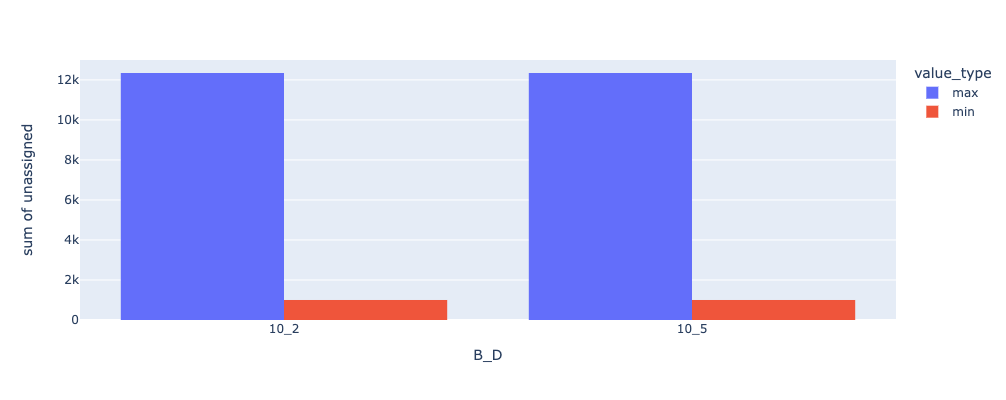

In [128]:
fig = px.histogram(df, x="B_D", y="unassigned",
             color='value_type', barmode='group',
             height=400)
fig.show()

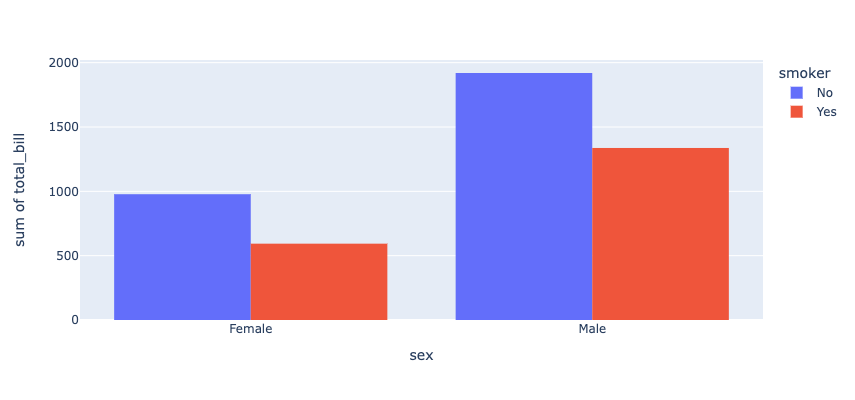

In [113]:
fig = px.histogram(df, x="sex", y="total_bill",
             color='smoker', barmode='group',
             height=400)
fig.show()

In [83]:
iss2 = generator(3, 2, min_fill=.8,
                    bin_generator = correlated_capacities, seed=123, rem_cons=.8, dev=.1,
                    correlated_items = True)
len(iss2.items)
iss2.items

[[24, 20],
 [58, 67],
 [1, 1],
 [41, 44],
 [3, 3],
 [10, 11],
 [337, 279],
 [539, 513],
 [5, 5],
 [3, 3],
 [20, 21],
 [8, 11],
 [3, 3],
 [16, 20]]

In [56]:
x, y, z = test_bdf(d=2, U=10, ins_type='unif')

len items 30
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done


In [74]:
iss = generator(num_bins=10, num_resources=2, min_fill=.8, bin_generator = unif_bin, seed=123, rem_cons=.8, proc_rate=1)
iss

Items:
[[171, 107], [205, 123], [129, 101], [155, 654], [175, 267], [42, 89], [174, 26], [92, 92], [12, 34], [40, 11], [244, 4], [497, 266], [322, 12], [26, 34], [198, 5], [172, 143], [5, 196], [203, 661], [16, 386], [10, 18], [3, 2], [28, 0], [18, 312], [131, 222], [38, 24], [81, 69], [0, 111], [33, 144], [220, 18], [209, 5]]
Bins:
[[[393, 532], [76, 49]], [[63, 284], [17, 18]], [[221, 850], [33, 52]], [[490, 867], [92, 165]], [[81, 16], [13, 5]], [[693, 155], [90, 14]], [[585, 350], [116, 23]], [[261, 177], [25, 37]], [[838, 993], [182, 98]], [[711, 561], [43, 188]]]

In [76]:
iss = generator(num_bins=11, num_resources=2, min_fill=.8, bin_generator = unif_bin, seed=123, rem_cons=.8, proc_rate=1)
iss

Items:
[[220, 18], [81, 69], [33, 144], [673, 134], [26, 34], [129, 101], [198, 5], [12, 34], [244, 4], [43, 171], [86, 141], [322, 12], [18, 312], [209, 5], [0, 111], [92, 92], [42, 89], [205, 123], [171, 107], [40, 11], [155, 654], [3, 2], [16, 386], [172, 143], [5, 196], [38, 24], [131, 222], [175, 267], [28, 0], [10, 18], [203, 661], [174, 26], [497, 266]]
Bins:
[[[490, 867], [92, 165]], [[261, 177], [25, 37]], [[693, 155], [90, 14]], [[393, 532], [76, 49]], [[945, 508], [143, 62]], [[81, 16], [13, 5]], [[585, 350], [116, 23]], [[711, 561], [43, 188]], [[63, 284], [17, 18]], [[838, 993], [182, 98]], [[221, 850], [33, 52]]]

In [131]:
import shutil
shutil.rmtree(base_dir)

In [136]:
import os
import plotly
import plotly.express as px
import pandas as pd
ins_types = ['unif', 'rare', 'correlatrd1', 'correlatrd2', 'similar']
num_bins = [10, 30, 100]
num_res = [2, 5, 10]

base_dir = 'plot_unassignment'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

for ins_type in ins_types:
    instances = []
    for num_bin in num_bins:
        for dim in num_res:
            # os.makedirs(f'{base_dir}/B_{num_bin}_D_{dim}', exist_ok=True)
            # filename = f'{base_dir}/B_{num_bin}_D_{dim}/{ins_type}.html'
            filename = f'{base_dir}/{ins_type}.html'
            if os.path.exists(filename):
                # os.remove(filename)
                break
            print(f'ins_type:{ins_type}, bin:{num_bin}, dim:{dim}')
            alpha_arr, unassigned_rate, unassigned_total= test_bdf(d=dim, U=num_bin, ins_type=ins_type)
            
            max_unassigned = max(unassigned_total)
            max_index = unassigned_total.index(max_unassigned)
            max_alpha = alpha_arr[max_index]
            
            min_unassigned = min(unassigned_total)
            min_index = unassigned_total.index(min_unassigned)
            min_alpha = alpha_arr[min_index]
            
            instances.append([ins_type, f'{num_bin}_{dim}', 'max', max_unassigned, max_alpha])
            instances.append([ins_type, f'{num_bin}_{dim}', 'min', min_unassigned, min_alpha])
            
            # df = pd.DataFrame({
            #     "alpha": alpha_arr, 
            #     "積載率" : unassigned_rate,
            #     # "unassigned_total": unassigned_total
            #     })
            # fig = px.line(df, x="alpha", y="積載率")
            # plotly.offline.plot(fig, filename=filename)
    print(instances)
    df = pd.DataFrame(instances, columns = ['instance', 'B_D', 'value_type', 'unassigned', 'alpha'])
    print(df)
    fig = px.histogram(df, x="B_D", y="unassigned",
             color='value_type', barmode='group',
             height=400)
    plotly.offline.plot(fig, filename=filename)
    print('ploted graph')

ins_type:unif, bin:10, dim:2
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:unif, bin:10, dim:5
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:unif, bin:10, dim:10
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:unif, bin:30, dim:2
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:unif, bin:30, dim:5
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:unif, bin:30, dim:10
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:unif, bin:100, dim:2
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:unif, bin:100, dim:5
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:unif, bin:100, dim:10
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
[['unif', '10_2', 'max', 6944, 0.0], ['unif', '10_2', 'min', 6944, 0.0], ['unif', '10_5', 'max', 16588, 0.0], ['unif', '10_5', 'min', 16588

# average_alpha

In [211]:
#実験
import numpy as np
def average_bdf(d, U, iss):
    np.random.seed(123)
    # d -> 瓶の次元
    # U -> 瓶の本数
    
    # print('len items', len(iss.items))
    w0 = np.array([ item.requirements for item in iss.items ])
    item_total = len(iss.items)
    b0 = np.array([ bin.remaining for bin in iss.bins])
    x, y, z =[],[],[]
    c = 0
    
    check_percents = [0.25, 0.5, 0.75, 1.0]
    for k in np.arange(0.0, 2.01, 0.01):
        # if k / 2.0 in check_percents:
        #     print(f'Processing {(k/2.0)*100}% Done')
        w = w0.copy()
        B = b0.copy()
        # alpha = float(k)/100.
        alpha = k
        unassigned = []
        bins = [[] for j in range(U)]
        while len(w)>0:
            W = w.sum(axis=0)
            R = B.sum(axis=0) #残り容量の和（次元ごと）
            #次元の重要度
            s = (W**alpha)/(R+0.000001)**(2.-alpha) 
            BS = B@s #ビンのサイズ（次元統合後）
            WS = w@s #アイテムのサイズ（次元統合後）
            max_item_idx = np.argmax(WS)
            max_item = w[max_item_idx]
            for j in np.argsort(BS):
                remain = B[j]- max_item
                if np.all(remain>=0): #詰め込み可能
                    B[j]= remain
                    bins[j].append(max_item)
                    break
            else:
                unassigned.append(max_item)
            w = np.delete(w, max_item_idx, axis=0)
        x.append(alpha)
        y.append((item_total-len(unassigned))/item_total)
        z.append(np.sum(unassigned))
    return x, y, z

In [ ]:
import os
import plotly
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
ins_types = ['unif', 'rare', 'correlatrd1', 'correlatrd2', 'similar']
num_bins = [10, 30, 100]
num_res = [2, 5, 10]

base_dir = 'alpha_count'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

for num_bin in num_bins:
    for dim in num_res:
        instances = []
        for ins_type in ins_types:
            os.makedirs(f'{base_dir}/B_{num_bin}_D_{dim}', exist_ok=True)
            filename = f'{base_dir}/B_{num_bin}_D_{dim}/{ins_type}.html'
            if os.path.exists(filename):
                continue
            print(f'ins_type:{ins_type}, bin:{num_bin}, dim:{dim}')    
            U = num_bin
            d = dim
            alpha_count = { i:0 for i in np.arange(0.0, 2.01, 0.01)}
            for i in range(100):
                if i % 25 == 0:
                    print(f'ins_type:{ins_type}, bin:{num_bin}, dim:{dim} is {i}% Done')    
                
                if ins_type == 'unif':
                    iss = generator(num_bins=U, num_resources=d, min_fill=.8, bin_generator = unif_bin, seed=i, rem_cons=.8, proc_rate=1)
                elif ins_type == 'rare': 
                    iss = generator(num_bins=U, num_resources=d, min_fill=.8, bin_generator = unif_bin, seed=i, rem_cons=.8, proc_rate=.25)
                elif ins_type == 'correlatrd1':
                    iss = generator(num_bins = U, num_resources = d, min_fill=.8, bin_generator = correlated_capacities, 
                                seed=i, rem_cons=.8, dev=.1, correlated_items = False)
                elif ins_type == 'correlatrd2':
                    iss = generator(U, d, min_fill=.8,
                        bin_generator = correlated_capacities, seed=i, rem_cons=.8, dev=.1,
                        correlated_items = True)
                else:
                    iss = generator(U, d, min_fill=.7, bin_generator = similar, seed=i, dev=.2)

                alpha_arr, unassigned_rate, unassigned_total= average_bdf(d=dim, U=num_bin, iss=iss)
                
                # 全ての最小アルファを収集する
                min_unassigned = min(unassigned_total)
                min_unassigned_index = set([i for i, v in enumerate(unassigned_total) if v == min_unassigned ])
        
                # if len(min_unassigned_index) != len(unassigned_total):
                #     print(unassigned_total)
                
                for indx in min_unassigned_index:
                    min_alpha = alpha_arr[indx]
                    alpha_count[min_alpha] += 1
        
            ins_dict = {
                'alpha': [ i for i in np.arange(0.0, 2.01, 0.01)],
                'count': [ count for count in alpha_count.values() ]
            }
            
            df = pd.DataFrame(ins_dict, columns=['alpha', 'count'])
            fig = go.Figure(px.bar(df, x="alpha", y="count", height=400, template="simple_white"))
            fig.update_layout(
                xaxis = dict(
                    tickmode = 'linear',
                    tick0 = 0,
                    dtick = 0.1
                )
            )
            plotly.offline.plot(fig, filename=filename)

ins_type:correlatrd1, bin:100, dim:5
ins_type:correlatrd1, bin:100, dim:5 is 0% Done
ins_type:correlatrd1, bin:100, dim:5 is 25% Done
ins_type:correlatrd1, bin:100, dim:5 is 50% Done


In [183]:
alpha_count = { i:0 for i in np.arange(0.0, 2.1, 0.01)}
alpha_count[0.0] += 1
alpha_count[0.0] += 10
alpha_count[1.0] += 29


In [203]:
alpha_count = { i:0 for i in np.arange(0.0, 2.01, 0.01)}
# alpha_count.keys()


dict_keys([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.1300000000000001, 1.1400000000000001, 1.1500000000000001, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1

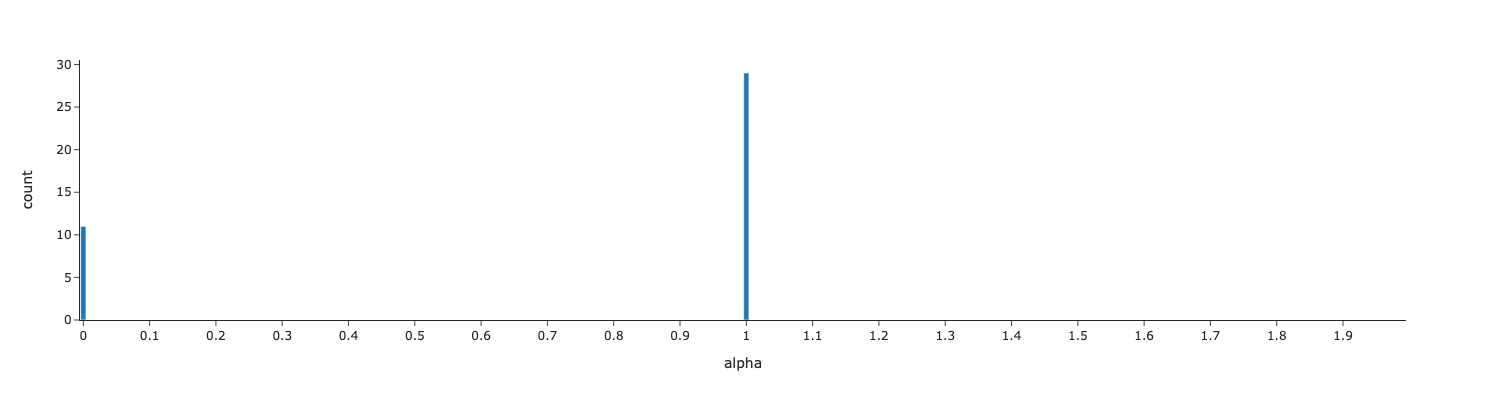

In [195]:
import plotly.graph_objects as go
ins_dict = {
            'alpha': [ i for i in np.arange(0.0, 2.0, 0.01)],
            'count': [ count for count in alpha_count.values() ]
        }
df = pd.DataFrame(ins_dict, columns=['alpha', 'count'])
fig = go.Figure(px.bar(df, x="alpha", y="count",
         height=400, template="simple_white"))

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 0.1
    )
)

fig.show()

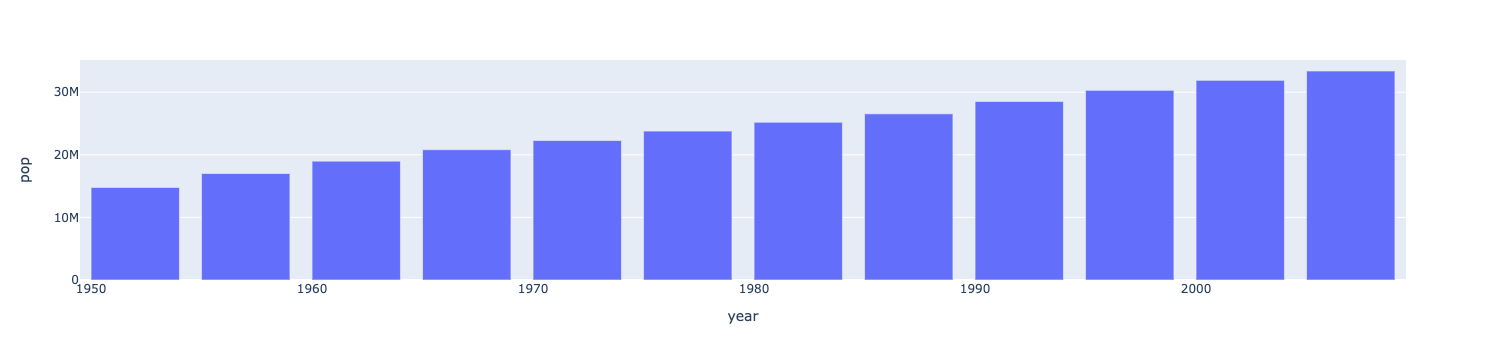

In [158]:
import plotly.express as px
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_canada, x='year', y='pop')
fig.show()

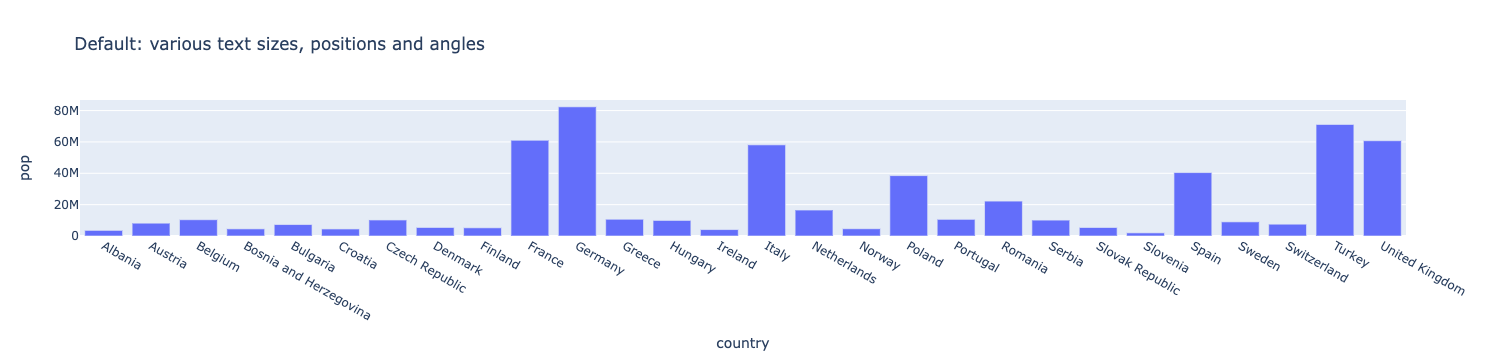

In [161]:
import plotly.express as px

df = px.data.gapminder().query("continent == 'Europe' and year == 2007 and pop > 2.e6")
fig = px.bar(df, y='pop', x='country', 
            title="Default: various text sizes, positions and angles")
fig.show()

In [159]:
data_canada

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
240,Canada,Americas,1952,68.750,14785584,11367.16112,CAN,124
241,Canada,Americas,1957,69.960,17010154,12489.95006,CAN,124
242,Canada,Americas,1962,71.300,18985849,13462.48555,CAN,124
243,Canada,Americas,1967,72.130,20819767,16076.58803,CAN,124
244,Canada,Americas,1972,72.880,22284500,18970.57086,CAN,124
245,Canada,Americas,1977,74.210,23796400,22090.88306,CAN,124
246,Canada,Americas,1982,75.760,25201900,22898.79214,CAN,124
247,Canada,Americas,1987,76.860,26549700,26626.51503,CAN,124
248,Canada,Americas,1992,77.950,28523502,26342.88426,CAN,124
249,Canada,Americas,1997,78.610,30305843,28954.92589,CAN,124


per_bin_dim

In [138]:
import os
import plotly
import plotly.express as px
import pandas as pd
ins_types = ['unif', 'rare', 'correlatrd1', 'correlatrd2', 'similar']
num_bins = [10, 30, 100]
num_res = [2, 5, 10]

base_dir = 'per_bin_dim'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

for num_bin in num_bins:
    for dim in num_res:
        instances = []
        for ins_type in ins_types:
            # os.makedirs(f'{base_dir}/B_{num_bin}_D_{dim}', exist_ok=True)
            filename = f'{base_dir}/B_{num_bin}_D_{dim}'
            # filename = f'{base_dir}/{ins_type}.html'
            
            if os.path.exists(filename):
                # os.remove(filename)
                break
            print(f'ins_type:{ins_type}, bin:{num_bin}, dim:{dim}')
            alpha_arr, unassigned_rate, unassigned_total= test_bdf(d=dim, U=num_bin, ins_type=ins_type)
            
            max_unassigned = max(unassigned_total)
            max_index = unassigned_total.index(max_unassigned)
            max_alpha = alpha_arr[max_index]
            
            min_unassigned = min(unassigned_total)
            min_index = unassigned_total.index(min_unassigned)
            min_alpha = alpha_arr[min_index]
            
            instances.append([ins_type, f'{num_bin}_{dim}', 'max', max_unassigned, max_alpha])
            instances.append([ins_type, f'{num_bin}_{dim}', 'min', min_unassigned, min_alpha])
            
            # df = pd.DataFrame({
            #     "alpha": alpha_arr, 
            #     "積載率" : unassigned_rate,
            #     # "unassigned_total": unassigned_total
            #     })
            # fig = px.line(df, x="alpha", y="積載率")
            # plotly.offline.plot(fig, filename=filename)
        print(instances)
        df = pd.DataFrame(instances, columns = ['instance', 'B_D', 'value_type', 'unassigned', 'alpha'])
        print(df)
        fig = px.histogram(df, x="instance", y="unassigned",
             color='value_type', barmode='group',
             height=400)
        plotly.offline.plot(fig, filename=filename)
        print('ploted graph')

ins_type:unif, bin:10, dim:2
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:rare, bin:10, dim:2
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:correlatrd1, bin:10, dim:2
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:correlatrd2, bin:10, dim:2
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
ins_type:similar, bin:10, dim:2
Processing 25.0% Done
Processing 50.0% Done
Processing 75.0% Done
[['unif', '10_2', 'max', 6944, 0.0], ['unif', '10_2', 'min', 6944, 0.0], ['rare', '10_2', 'max', 4639, 0.0], ['rare', '10_2', 'min', 4639, 0.0], ['correlatrd1', '10_2', 'max', 6588, 0.0], ['correlatrd1', '10_2', 'min', 6588, 0.0], ['correlatrd2', '10_2', 'max', 6065, 0.0], ['correlatrd2', '10_2', 'min', 6065, 0.0], ['similar', '10_2', 'max', 5174, 0.0], ['similar', '10_2', 'min', 5172, 0.46]]
      instance   B_D value_type  unassigned  alpha
0         unif  10_2        max        6944   0.00
1         

## ２次元パッキング問題


**2次元（長方形；矩形）パッキング問題** (2-dimensioanl rectangular packing problem) は, 与えられた長方形を平面上に互いに重ならないように配置する問題である．

長方形集合 $I=\{1,2,\ldots,n\}$ の各要素 $i$ は $m_i$ 種類のモードが与えられ, 各モード  $k(=1,2,\ldots,m_i)$ に対して， 幅 $w_i^k$ と高さ $h_i^k$ がが与えられる. 
配置は, 各長方形について 1つのモードを選択し, さらに左下の位置の座標値  $(x,y)$ を与えることで定まる. 
配置はなるべくコンパクトなことが望ましく， $x,y$ 軸に対して区分的線形な費用関数を定義することによって，目的関数を定める．

以下，パラメータである．

- size 長方形数
- pft_x x 軸コストがあるかどうか (0: あり, 1: なし (w,xgr を利用))
- pft_y y 軸コストがあるかどうか (0: あり, 1: なし (h,ygr を利用))
- w 入れ物の幅 (x 軸コストが無い場合のみ意味あり) -xgr x方向, 入れ物からの超過に対するペナルティの傾き -h 入れ物の高さ (y 軸コストが無い場合のみ意味あり) -ygr y方向, 入れ物からの超過に対するペナルティの傾き
time=2.77
- time 最大計算時間 (終了条件)
- move 最大移動回数 (終了条件)
- lopt 最大局所最適解数 (終了条件, MLS, ILSのみ意味あり) -h_type メタ戦略の種類 (1: 局所探索, 2: MLS, 3: ILS)


In [35]:
#export
def packingmeta(fn, timelimit):
    f = open(fn)
    data = f.readlines()
    f.close()
    n = len(data)
    cmd = f'./2pp {fn} -time {timelimit} -size {n}  >packing.out'
    try:
        o = subprocess.run(cmd, shell=True, check=True)
    except subprocess.CalledProcessError as e:
        print('ERROR:',e.stderr)
    f = open("packing.out")
    data = f.readlines()
    f.close()
    start = data.index(" ID: (x, y)		 [w, h] \n")
    opt_val = float(data[start-3].split()[3][:-1])
    xy, wh ={}, {}
    for i, row in enumerate(data[start+1:]):
        r = row.split()
        xy[i] = float(r[1][1:-1]), float(r[2][:-1])
        wh[i] = float(r[3][1:-1]),float(r[4][:-1])
    x, y = [],[]
    for i in xy:
        xx,yy = xy[i]
        w, h  = wh[i]
        x.extend([xx, xx+w,xx+w,xx,None])
        y.extend([yy,yy,yy+h,yy+h,None])
    fig = go.Figure(go.Scatter(x=x, y=y, fill="toself"))
    return opt_val, xy, wh, fig

In [36]:
fn = folder + "ami33"
fn = folder + "rp200"
timelimit = 1
opt_val, xy, wh, fig  = packingmeta(fn, timelimit)
print("obj",opt_val)
plotly.offline.plot(fig);

obj 1313.0


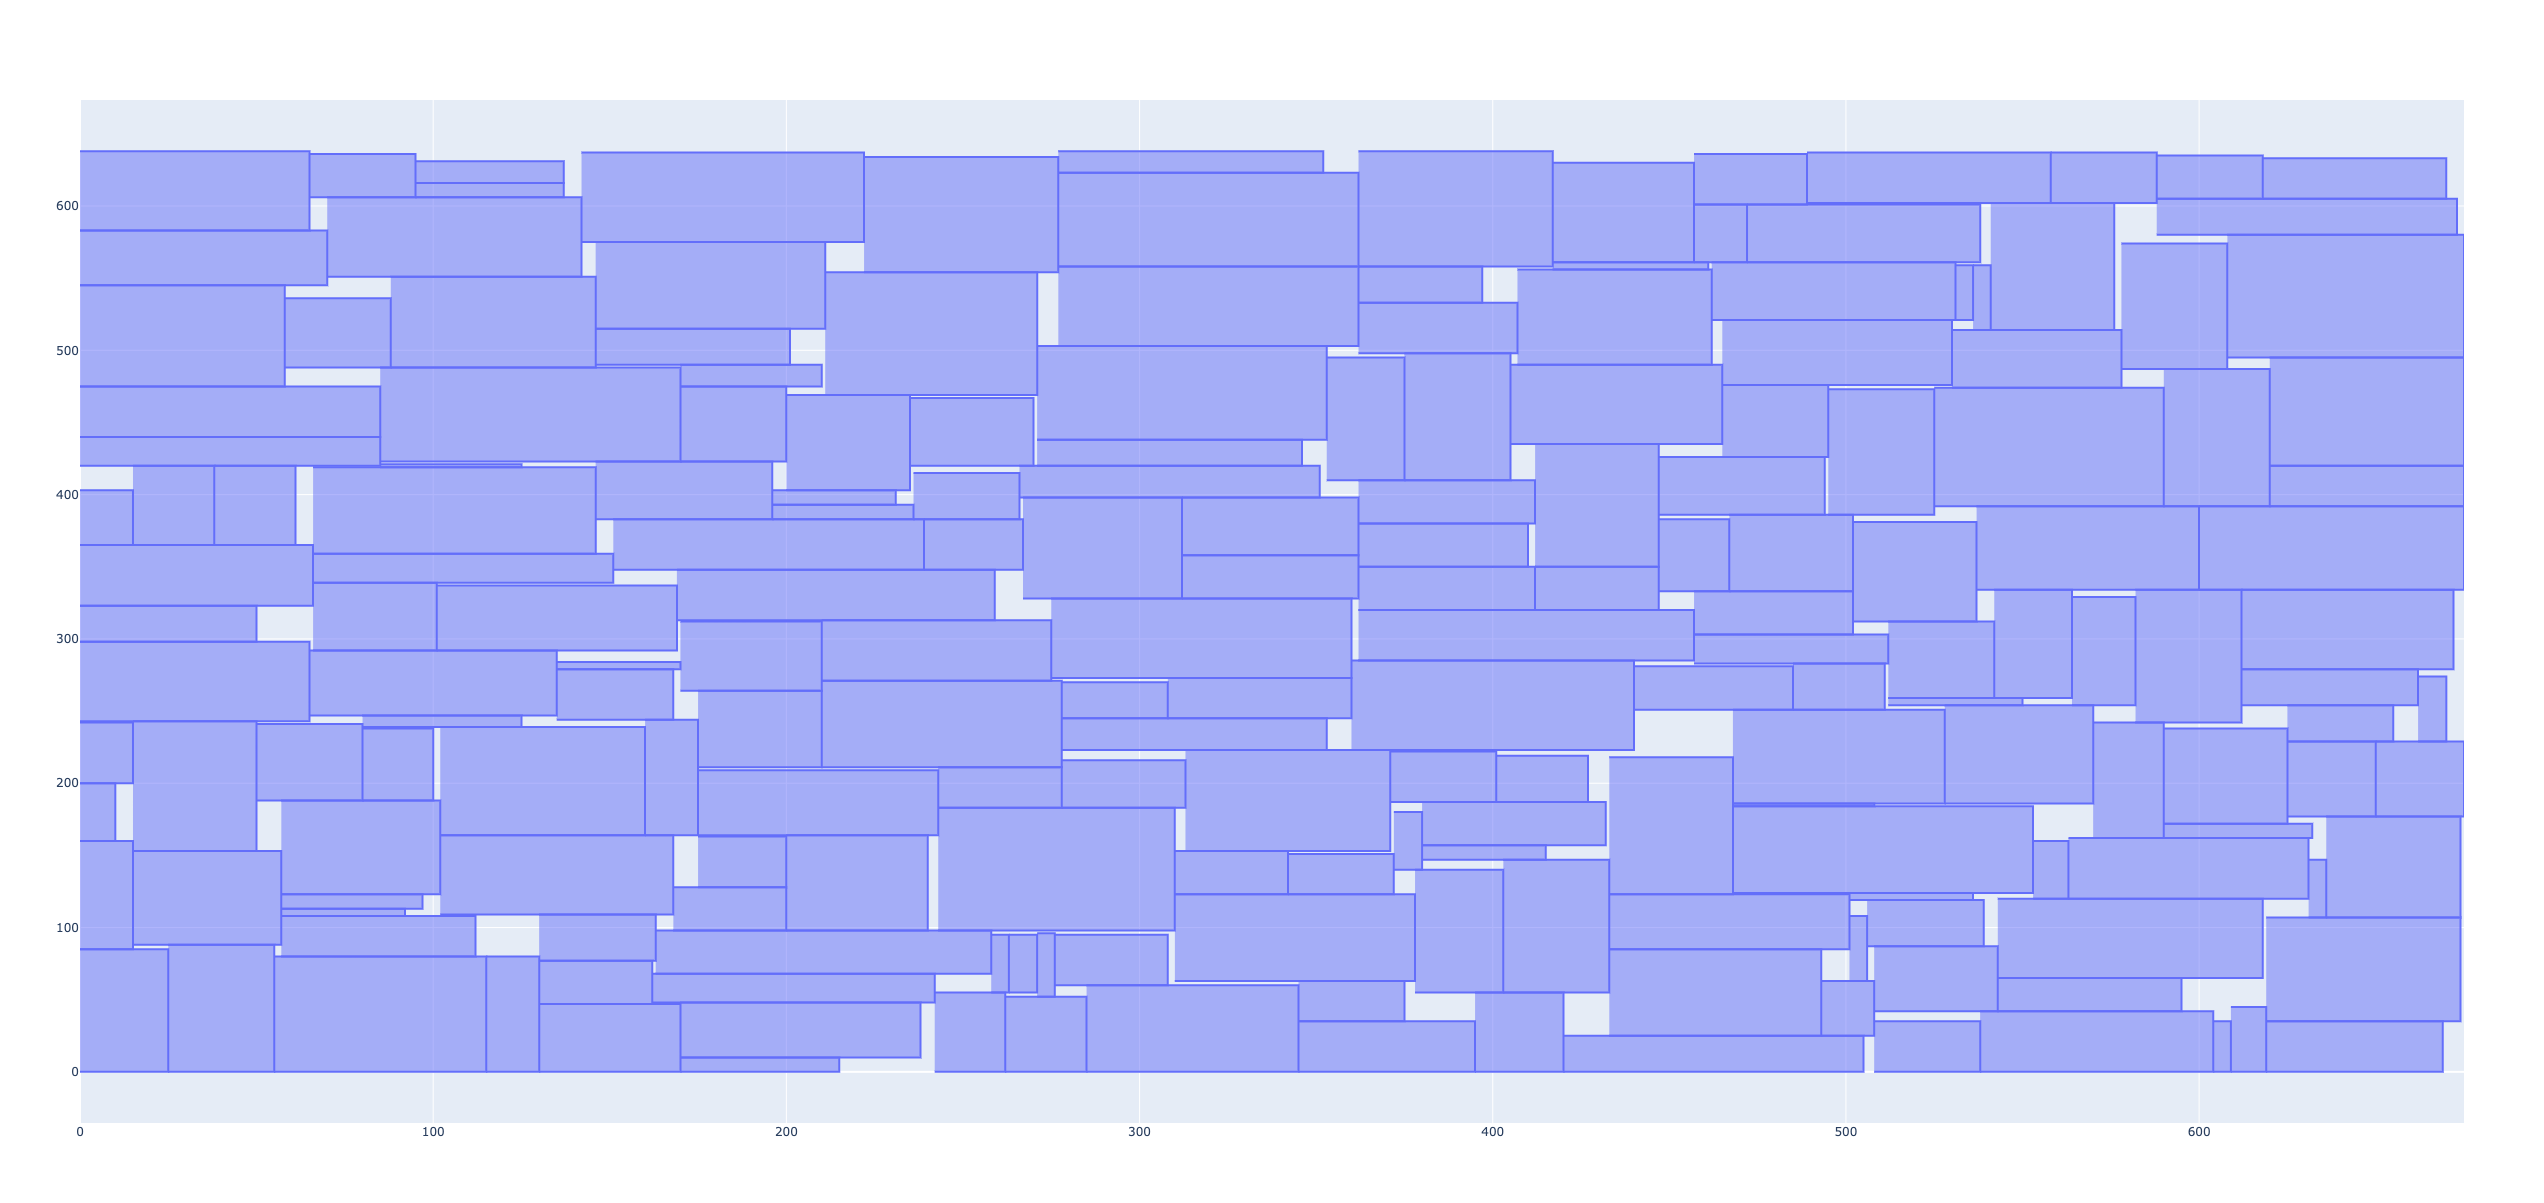

In [6]:
#hide_input
Image("../figure/2dbpp.png")

## 確率的ビンパッキング問題

幾つかのビンパッキング問題の応用では，アイテムに関する情報が事前に与えられておらず，
時間の経過とともにアイテムが到着し，そのサイズが判明するケースがある．
このような仮定を課した問題を**オンラインビンパッキング問題**（online bin packing problem）とよぶ．
より正確に言うと，先に到着するアイテムについての情報をもたずに入れるビンを決め，さらに1度入れたら，それを移動することができないという制限を課した問題である．

この条件を少し緩和した問題として，到着するアイテムのサイズの確率分布が既知であると仮定した問題が考えられる．
このような問題を**確率的ビンパッキング問題**(stochastic bin packing problem)とよぶ．

実務における問題は，オンラインと確率的の両者の性質をもつ．　以下の分類にしたがって，解法を選ぶことが望ましい．

- 分布が未知で未来の情報がまったくない： オンラインビンパッキングのヒューリスティクスを用いる．
- 分布が定常：確率分布を推定し，確率的ビンパッキング問題として解く．
- 分布が非定常：オンラインで到着するアイテムのサイズから適応的に分布を推定し，ヒューリスティクスを適用する．
- 近い未来の情報は既知で，ある時点以降の情報がまったくない： 既知の部分までを確定的な問題として求解して，ローリングホライズン方式を適用する． 
- 近い未来の情報は既知で，先に行くに従って情報が不確実になる： 既知の部分までを確定的な問題として求解して，ローリングホライズン方式を適用するが，確率的な情報を利用して，最終状態を適正なものに近づける．


アイテムのサイズを離散値とした確率的ビンパッキング問題を考える．

ビンの容量を正の整数 $B$ とする．
アイテムのサイズの種類は $J$ 種類であり，小さい方から順に $s_1 <s_2 <\cdots <s_J$ とする．
ここで $s_j (j=1,\cdots,J)$ は $[1,b]$ の整数とする．サイズが $s_j$ のアイテムが発生する確率を $p_j$ とする．
ここでは，$p_j$ は非負の有理数であり，その和は $1$ であるとする．
$i$番目のアイテムは，独立に確率 $p_j$ でサイズ $s_j$ になるように決められる．


サイズ $s_j$ のアイテムを高さ $h$ のビンに割り当てる確率を表す実数変数 $x_{jh}$ を用いた以下の線形最適化問題を導入する．

$$
\begin{array}{l l l }
minimize &  \sum_{h=1}^{B-1} (B-h) \cdot \left(\sum_{j=1}^J x_{j,h-s_j}-\sum_{j=1}^J x_{jh} \right)  &      \\
s.t.  & \sum_{h=0}^{B-1} x_{jh} =p_j                      & j=1,\cdots,J \\
                  & \sum_{j=1}^J x_{jh} \leq \sum_{j=1}^J x_{j,h-s_j} & h=1,\cdots,B-1 \\
                  & x_{jh} \geq 0 & j=1,\cdots,J,h=0,\cdots,B-1 \\
                  & x_{jh} =0     & j=1,\cdots,J,h=B-s_j+1,\cdots,B-1
\end{array}
$$

目的関数は，ビンの余り $(B-h)$ が超過して生成される率に，余り $(B-h)$ を乗じたものを最小化することを表す．
最初の制約は，サイズ $s_j$ のアイテムがいずれかのビンに割り当てられる率が，発生する確率に等しいことを表す．
2番目の制約は，高さ $h$ が生成される確率（式の右辺）が，消滅する確率（式の左辺）以上であることを表す．
3番目の制約は，変数の非負条件であり，最後の制約はビンのサイズの上限を超えてしまう割り当て確率が $0$ であることを表す．

In [24]:
from scipy.stats import rv_discrete 
B= 10
s = [1,2,5,6]
p = [0.3,0.3,0.3,0.1]
J = len(s)
size = rv_discrete(values=(s,p))

In [27]:
model = Model("discrete bpp")
x, slack = {}, {}
for j in range(J):
    for h in range(B):
        if s[j]+h<=B-1:
            x[j,h] = model.addVar(vtype = "C", name=f"x[{j},{h}]")
for h in range(1,B):
    slack[h] = model.addVar(vtype="C", name=f"slack[{h}]")
model.update()
for j in range(J):
    model.addConstr( quicksum(x[j,h] for h in range(B) if (j,h) in x )==p[j] )
for h in range(1,B):
    model.addConstr( quicksum(x[j,h] for j in range(J) if (j,h) in x) + slack[h] == quicksum(x[j,h-s[j]] for j in range(J) if h>=s[j]) )
model.setObjective(  quicksum( (B-h)*slack[h] for h in range(1,B) ), GRB.MINIMIZE)

In [28]:
model.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 13 rows, 35 columns and 83 nonzeros
Model fingerprint: 0x935e3513
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e-01]
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolved: 11 rows, 32 columns, 74 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.500000e-01   0.000000e+00      0s
       9    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.01 seconds
Optimal objective  1.000000000e+00


In [29]:
for (j,h) in x:
    if x[j,h].X > 0.001:
        print(j,h,x[j,h].X)

0 0 0.1
0 5 0.09999999999999999
0 6 0.09999999999999999
1 0 0.049999999999999996
1 2 0.049999999999999996
1 7 0.2
2 0 0.25
2 4 0.049999999999999996
3 1 0.1


In [30]:
for h in range(1,B):
    print(h, slack[h].X )

1 0.0
2 0.0
3 0.0
4 0.0
5 0.15000000000000002
6 0.0
7 0.0
8 0.0
9 0.25


## オンラインビンパッキング問題

上で示したfirst fit decreasingはオフラインでしか使えず， first fitはオンラインで使えるが性能が悪い．
改良版としてbest fitヒューリスティクスがある．

#### best fit (BF) ヒューリスティクス

アイテムを $1,2,\cdots,n$ の順にビンに詰めていく．
このとき，アイテムは詰め込み可能な最大の高さをもつビン（同点の場合には最小添字のビン）に詰めるものとする．
どのビンに入れてもサイズの上限 $1$ を超えてしまうなら，新たなビンを用意し，そこに詰める．

以下では， オンラインの環境下で離散分布の場合に良い性能を示す**2乗和法**（sum-of-square algorithm）を紹介する．

途中までアイテムを詰めた状態を考える．
このとき，アイテムのサイズは整数であるので，空でなくかつ一杯になっていないビンの高さ $h$ は $[1,B-1]$ の整数である．
高さが $h$ のビンの数を $M(h)$ と書く．
オンラインの環境下においては，将来どのようなサイズが到着するか分からないと仮定するが，
このような状態における策として，$M(h)$ がなるべく均等になるように準備しておく方法が考えられる．
もし，すべての高さのビンがあれば，どのようなアイテムが到着しても，ビンの高さがちょうど $B$ になるように詰めることができるからである．

均等にするための常套手段として，2乗和を最小化する方法がある．
和が一定の数の分割において，2乗和が最小になるのは，すべての数が同じ場合である．
（たとえば，$9$ の3分割では，$3^2+3^2+3^2=27$ が最小で，$9^2+0^2+0^2=81$ が最大になる．）
2乗和法では，このアイディアに基づいて，以下の指標を最小にするビンにアイテムを入れる．
$$
 SS= \sum_{h=1}^{B-1} M(h)^2
$$

サイズ $w$ のアイテムを，高さ $h$ のビンに入れたときの上の指標の増加量 $\Delta$ は，
$$
\Delta=
\left\{ 
\begin{array}{l l }
  2M(w)+1   &  新しいビンを生成するとき  （h=0） \\
  -M(B-w)+1 &  ビンが一杯になったとき  （h=B-w） \\
  2(M(h+w)-M(h))+2 & その他  
\end{array}
\right.
$$
と計算できる．したがって，指標 $SS$ を最小にする高さを求めるには，2乗和を再計算する
必要はなく，$\Delta$ を最小にする $h$ を求めれば良い．これは $O(B)$ 時間でできる．


In [37]:
B= 10
s = [1,2,5,6]
p = [0.3,0.3,0.3,0.1]
J = len(s)
size = rv_discrete(values=(s,p))
n = 10000

In [41]:
import numpy as np
M = np.zeros(B+1,dtype=int)
w = size.rvs(size=n)
for i in range(n):
    min_delta = 2*w[i] + 1 
    best_h = 0
    for h in range(1,B+1-w[i]):
        if M[h]==0:
            continue
        if h+w[i] == B:
            delta = -M[h]+1
        else:
            delta =2*(M[h+w[i]]-M[h]) + 2
        if delta < min_delta:
            min_delta = delta 
            best_h = h
    #print(M, "item",w[i],"is add to bin with height",best_h)
    if best_h > 0:
        M[best_h] -=1
    M[best_h+w[i]] += 1
print(M)

[   0    0    0    0    0    0    1    1    0    2 3018]


In [42]:
def BF(s,B):
    """Best Fit heuristics for the bin Packing Problem.
    Parameters:
        - s: list with item widths
        - b: bin capacity
    Returns a list of lists with bin compositions.
    """    
    remain = [B]        # keep list of empty space per bin
    sol = [[]]          # a list ot items (i.e., sizes) on each used bin
    
    for item in s:
        best_remain = np.inf
        best_j = -1
        for (j,free) in enumerate(remain):
            rem = free - item
            if rem ==0:
                best_remain = rem
                best_j = j 
                break
            elif rem >0 and rem < best_remain:
                best_remain = rem
                best_j = j 
        if best_j >=0:
            remain[best_j] -= item
            sol[best_j].append(item)
        else: #does not fit in any bin
            sol.append([item])
            remain.append(B-item)
    return sol    

In [43]:
sol = BF(w,B)
print(len(sol))

3022
